<a href="https://colab.research.google.com/github/FedericoRaschiatore0123/Neural_Network/blob/main/Adversarial_Diffusion_Distillation_Last_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Method Description

The Adversarial Diffusion Distillation (ADD) is a novel approach that aims to efficently samples images in just a few steps.The idea is combine the power of Adversarial networks and the distillation technique in order to synthetize high quality images in a small number of iterations.

In the original paper Sauer et. al. the idea was to synthetize the images in 1-4 steps using pretrained models. Their analysis show that the models outperform the results of existing models and reach the performances of the State of the art (SDXL) in only 4 steps.

The original model is composed by 3 parts:


*   **ADD-student**: is a pretrained diffusion model that aims to synthetize the images in a few steps (1-4) starting from a noised version of the original image. So this model can use only from 1 to 4 iterations to denoise the input image. The parameters of this model are trainable.
*   **DM-teacher**: is also a pretrained diffusion model but differently from the student, it can use a larger number of iterations to denoise the input. It has fixed parameters.
*   **ViT Discriminator**: is a pretrained Vision Transformer that they adapt to use as a discriminator with trainable parameters.

The key idea for the training procedure is:

1.   Take a Real image
2.   Introduce some noise
3.   Pass the noised version of the original image through the ADD-student
4.   Pass the output of ADD-student through the discriminator and compute the Adversarial Loss
5.   Introduce some other noise to the resulting image from the ADD-student
6.   Pass it through the DM-teacher and compute the distillation loss using the outputs from the ADD-student and DM-teacher
7.   Compute the total loss summing up the two losses and backpropagate it to the ADD-student and to the discriminator

The two losses that have been computed are the Adversarial Loss and the Distillation Loss that are defined as follows:

Adversarial loss that is the loss of the adversarial process and is used to update the weights of the discriminator:


$$L_{adv}^G(\hat{x}_{\theta}(x_s, s), \phi) = -\mathbb{E}_{s,\epsilon,x_0} \left[ \sum_{k} D_{\phi,k} \left( F_k(\hat{x}_{\theta}(x_s, s)) \right) \right] $$

$$L_{adv}^D(\hat{x}_{\theta}(x_s, s), \phi) = \mathbb{E}_{x_0} \left[ \sum_{k} \max(0, 1 - D_{\phi,k}(F_k(x_0))) + \gamma R_1(\phi) \right] + \mathbb{E}_{\hat{x}_{\theta}} \left[ \sum_{k} \max(0, 1 + D_{\phi,k}(F_k(\hat{x}_{\theta}))) \right]
$$


Distillation loss:

$$L_{\text{distill}}(\hat{x}_{\theta}(x_s, s), \psi) = \mathbb{E}_{t,\epsilon'} \left[ c(t) \cdot d(\hat{x}_{\theta}, \hat{x}_{\psi}(s, g(\hat{x}_{\theta}, t); t)) \right]$$



The total loss is:

$$L_{total} = L_{adv}^D(\hat{x}_{\theta}(x_s, s), \phi) + L_{\text{distill}}(\hat{x}_{\theta}(x_s, s), \psi)$$



To avoid the use of pretrained model i implemented a Denoise diffusion model and a Discriminator model based on a ViT architecture as can be seen below.


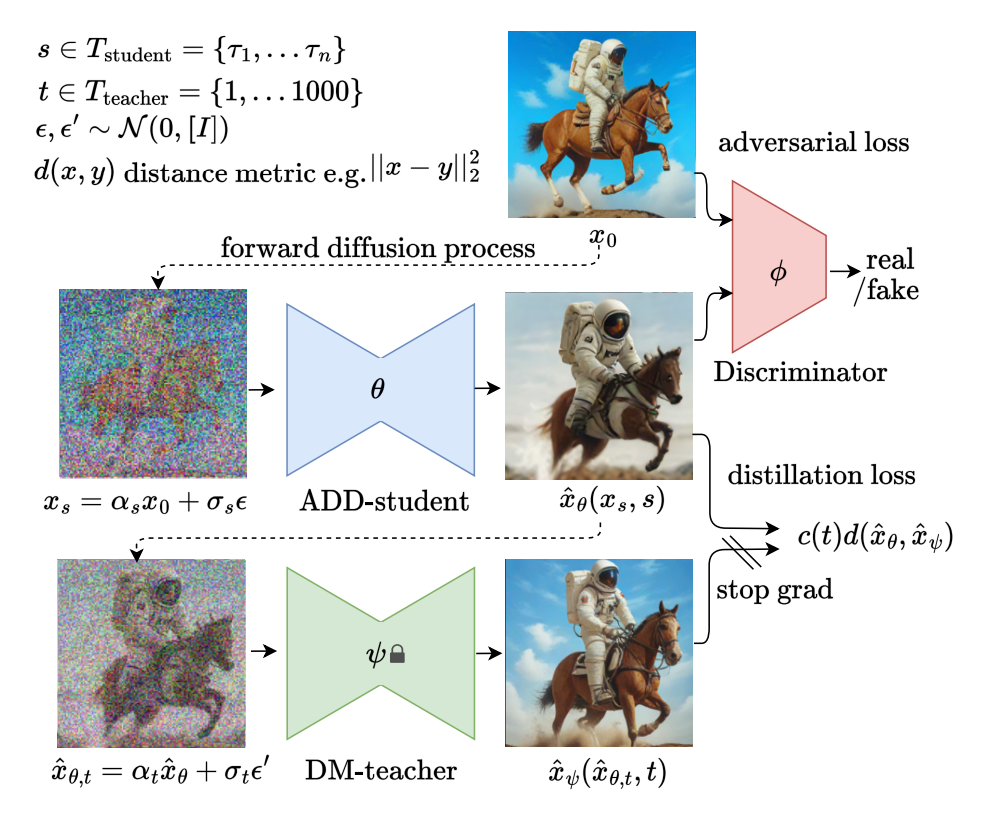

https://static1.squarespace.com/static/6213c340453c3f502425776e/t/65663480a92fba51d0e1023f/1701197769659/adversarial_diffusion_distillation.pdf

https://arxiv.org/pdf/2006.11239.pdf


## Import the pretrained models


Here you can download the pretrained models for the ADD-student, DM-teacher and ViT discriminator from the github and use them to test the results.

In [1]:
!rm -r Neural_Network
!git clone https://github.com/FedericoRaschiatore0123/Neural_Network
%cd Neural_Network
!unzip models.zip -d models

rm: cannot remove 'Neural_Network': No such file or directory
Cloning into 'Neural_Network'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 150 (delta 6), reused 0 (delta 0), pack-reused 138
Receiving objects: 100% (150/150), 67.93 MiB | 17.20 MiB/s, done.
Resolving deltas: 100% (112/112), done.
/content/Neural_Network
Archive:  models.zip
  inflating: models/models/diffusion_model_last_version.pth  
  inflating: models/models/discriminator_model_last_version.pth  
  inflating: models/models/student_model_last_version.pth  


#Imports
the project has been built using the following libraries, in particular pytorch and torchvision. In addition i decided to use libraries as numpy and einops to do some particular operations and

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
!pip install -q -U einops datasets matplotlib tqdm

import math
import torch as torch
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange
from torch import einsum
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import os
import torch.nn as nn
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid , save_image
import random
from torchvision import datasets
from torch.optim import Adam
from pathlib import Path

!pip install pytorch-ignite
!pip install pytorch-fid
import ignite.metrics
from pytorch_fid.inception import InceptionV3
from torchvision.transforms.functional import to_pil_image, to_tensor

BATCH_SIZE=64

device = "cuda" if torch.cuda.is_available() else "cpu"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.4/272.4 kB 4.4 MB/s eta 0:00:00


#Dataset and transformations
In this section it's imported the dataset and are applied the following transformations.

In [4]:
transform = tt.Compose([
            tt.RandomHorizontalFlip(),
            tt.ToTensor(),
            tt.Lambda(lambda t: (t * 2) - 1)
])

dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

print(dataset)
# create dataloader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 135352141.49it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 115038645.61it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41256145.25it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 18126097.78it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Lambda()
           )


In [5]:
def show_batch(images):
    fig, ax = plt.subplots(figsize=(24, 24))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images[:32], nrow=8).permute(1, 2, 0))

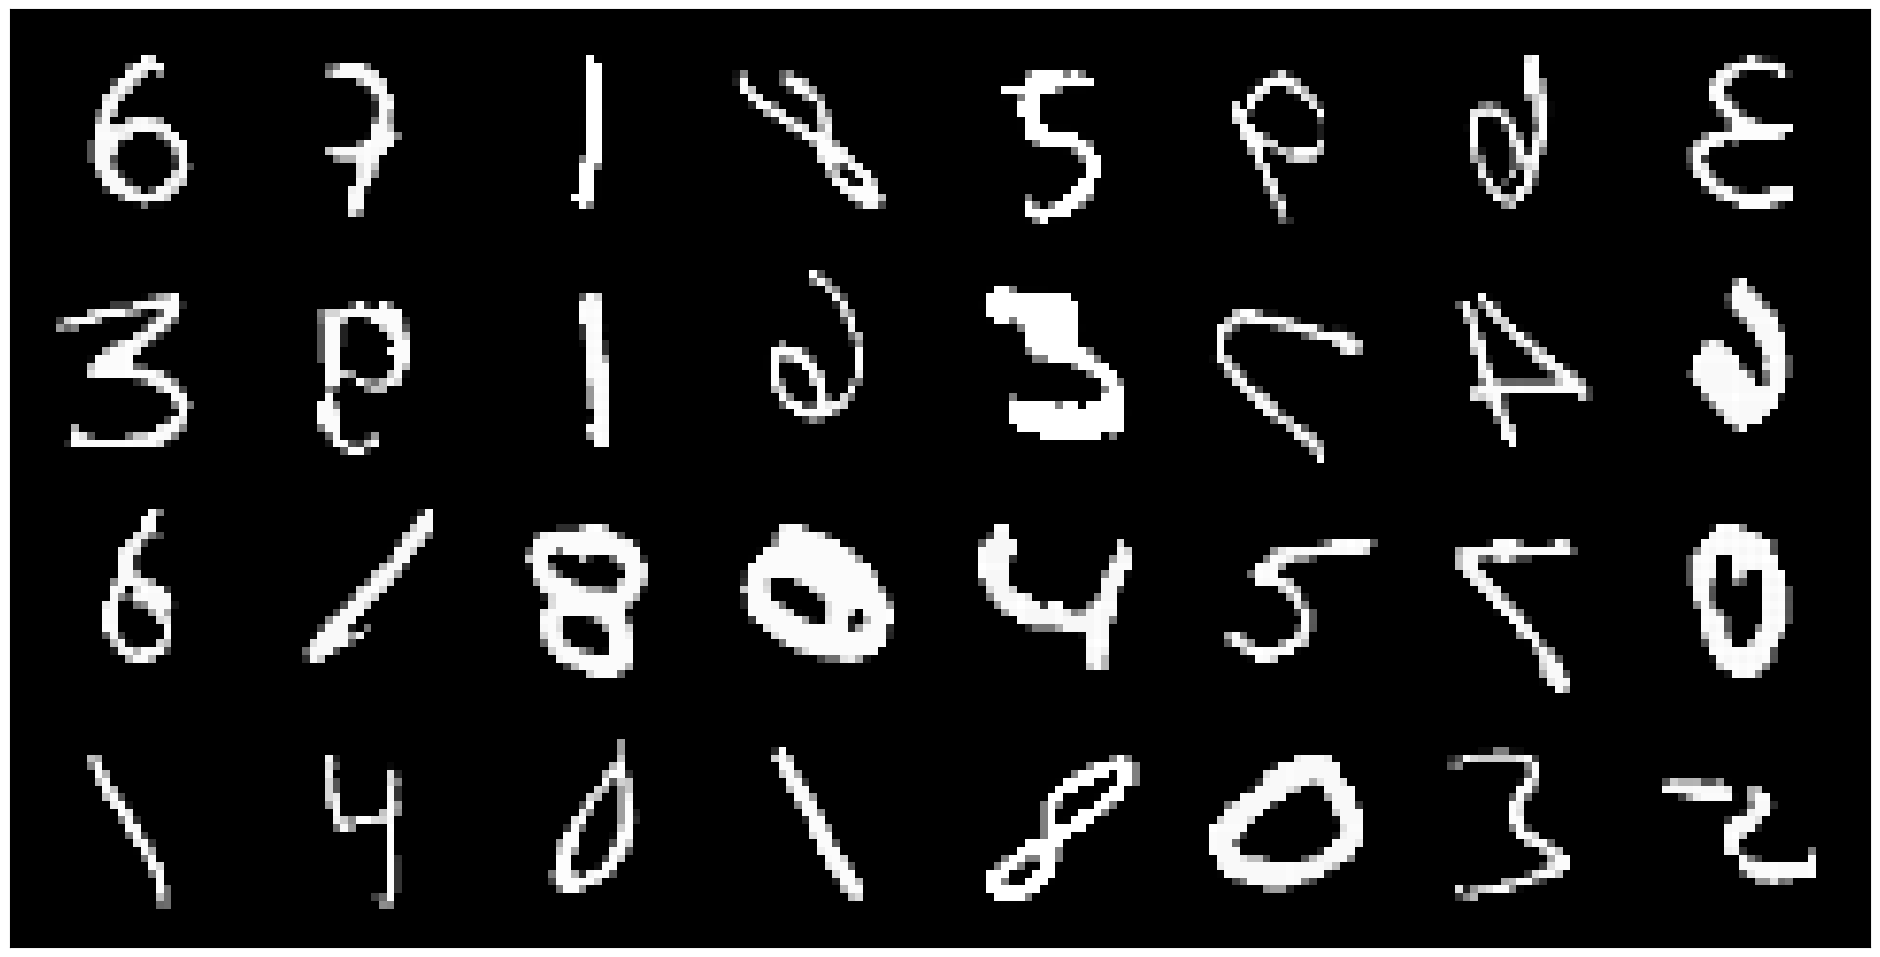

In [6]:
show_batch(next(iter(dataloader))[0])

#Forward process
In this section is sets up the foundational elements for a diffusion model, including the calculation of key parameters based on a linear schedule of noise levels (betas) and the implementation of the forward diffusion process, where an input data point is progressively noised according to the diffusion schedule.

In [7]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu()) #gather the value from a as specified in t
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device) #and reshape following x_shape

timesteps = 800

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. -  betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise, noise

In [8]:
def show_tensor_image(image):
    reverse_transforms = tt.Compose([
        tt.Lambda(lambda t: (t + 1) / 2),
        tt.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        tt.Lambda(lambda t: t * 255.),
        tt.Lambda(lambda t: t.numpy().astype(np.uint8)),
        tt.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))


torch.Size([64, 1, 28, 28])


<ipython-input-9-f27da4a9ee29>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


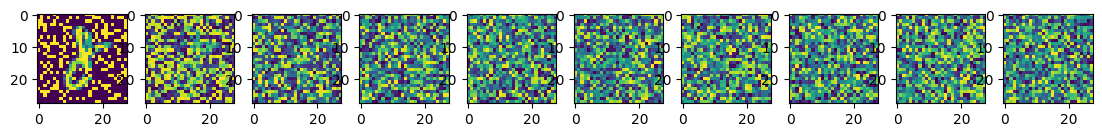

In [9]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]
print(image.shape)

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(timesteps/num_images)

for idx in range(1, timesteps, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = q_sample(image, t)
    show_tensor_image(img)

# Diffusion Model

In this section is implemented the diffusion model and all its components. The aim of the diffusion model is learn how to denoise the images that have been noised in the precedent forward pass. In particular this model have to predict the noise that have been inserted in in the original image.
The architecture is based on a UNet model that pass the image through some residual block of convolutional layers, than downsample and repeat until we reach the desired resolution. After that the image is upsampled and pass through other convolutional layers until reach the original resolution.

In this prcess it's extracted the estimated noise that is compared to the real noise and with this two values we compute the loss that will be backpropagated.

The architecture is based on the paper Denoising diffusion probabilistic model ( https://arxiv.org/pdf/2006.11239.pdf )
  
<p align="center">
    <img src="https://nn.labml.ai/unet/unet.png" width="600" />
</p>

##UNeT

In this section are implemented some function that are useful for all the process. Are also implemented the class Residual that implement the residual connection mechanism and the Prenorm function that is used to normalize the datas

In [10]:
#Utilities
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn=fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)


The noise level is sampled randomly in a range \[ 0, timestep \], so to give information to the model about the level of noise in which it is operating we give an embedding to that specific value using this class that using sine and cosine give an embedding value.

In [11]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In this section we define the convolution block and the residual convolution block.
The UnetBlock is the key block of the architecture, is composed by a convolutional layer, a gruop normalization block that normalize the datas and a Sigmoid Linear Unit as activation function.


The ResNet represent each layer of the UNet model that we have seen above:

*   We have a first convolutiona block
*   We concatenate the results of the Sinusoidal Positional Embedding to the output of the first block
*   We pass the result h through another convolutional layer
*   We sum up the original input x to the output in order to form a residual connection



In [12]:
class UNet_Block(nn.Module):
  def __init__(self, dim_input, dim_output, groups=4):
    super().__init__()
    self.proj = nn.Conv2d(dim_input, dim_output, 3, padding = 1)
    self.normalization= nn.GroupNorm( groups, dim_output)
    self.act= nn.SiLU()

  def forward(self, x):
    x = self.proj(x)
    x = self.normalization(x)
    x = self.act(x)

    return x

class UNet_ResNet(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=4):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = UNet_Block(dim, dim_out, groups=groups)
        self.block2 = UNet_Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)

The authors also intorduced some multi-head attention layers between the various convolutional layer,that are implemented as follows.
The Attention layer is used in the middle part of the UNet instead the LinearAttention is used after each downsample or upsample layer.

In [13]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.num_heads = num_heads
        hidden_dim = dim_head * num_heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.num_heads), qkv
        )
        #batch, num_heads, dim_features, x, y
        #organizza le informazioni ottenute dalla proiezione lineare in q, k, e v nel formato appropriato
        q = q * self.scale

        #specifica come fare la moltiplicazione tra il vettore q (batch, num_heads, dim_features, index(i)) e k(batch, num_heads, dim_features, index(j))
        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)


class LinearAttention(nn.Module):
    def __init__(self, dim, num_heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = num_heads
        hidden_dim = dim_head * num_heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

Finally we can define the complete UNet. This take in input the batch of noised images and the noise level t and have to predict the noise in the batch.
What we do is define a sequence of layers each one composed by a UNet_Resnet block, a Linear Attention block and a downsampling/upsampling layer.  

In [14]:
class Unet(nn.Module):
    def __init__( self, dim, init_dim=None, out_dim=None, dim_mults=(1, 2, 4, 8), channels=1, with_time_emb=True, resnet_block_groups=4, convnext_mult=2):
        super().__init__()

        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)] #dim * [1,2,4,8]
        in_out = list(zip(dims[:-1], dims[1:]))  #dim * [1,2,4,8,4,2,1]

        block_klass = partial(UNet_ResNet, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),

                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )


    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

In [15]:
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise


def p_sample_loop(model,img, shape, timesteps):
    device = next(model.parameters()).device

    b = shape[0]
    imgs = []

    for i in reversed(range(0, timesteps)):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img)
    return imgs

def sample(model, img, image_size, timestep, batch_size=BATCH_SIZE, channels=1):
    return p_sample_loop(model, img,  shape=(batch_size, channels, image_size, image_size), timesteps=timestep)

##Train

The model has been trained for 10 epochs using an Adam optimizer and a scheduler in order to adapt the learning rate during the training procedure.

In [ ]:
image_size = 28
channels = 1
batch_size = 64

diffusion_model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
diffusion_model.to(device)


In [ ]:
epochs = 10

optimizer = Adam(diffusion_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch[0].shape[0]
      batch = batch[0].to(device)

      t = torch.randint(0, timesteps, (batch_size,), device=device).long()
      noise=torch.randn_like(batch)
      x_noisy = q_sample(x_start=batch, t=t, noise=noise)
      predicted_noise = diffusion_model(x_noisy[0], t)

      loss = F.smooth_l1_loss(noise, predicted_noise)

      if step % 200 == 0:
        print("Epoch: " + str(epoch)+ "   Loss:", loss.item())

      loss.backward()
      optimizer.step()

    scheduler.step(loss)

Epoch: 0   Loss: 0.47786423563957214
Epoch: 0   Loss: 0.031613025814294815
Epoch: 0   Loss: 0.021020693704485893
Epoch: 0   Loss: 0.016482125967741013
Epoch: 0   Loss: 0.01786305569112301
Epoch: 1   Loss: 0.01804881915450096
Epoch: 1   Loss: 0.021129949018359184
Epoch: 1   Loss: 0.019465584307909012
Epoch: 1   Loss: 0.015356360003352165
Epoch: 1   Loss: 0.014584672637283802
Epoch: 2   Loss: 0.012611252255737782
Epoch: 2   Loss: 0.01488986425101757
Epoch: 2   Loss: 0.014702427200973034
Epoch: 2   Loss: 0.016041772440075874
Epoch: 2   Loss: 0.010167320258915424
Epoch: 3   Loss: 0.016576694324612617
Epoch: 3   Loss: 0.011605627834796906
Epoch: 3   Loss: 0.015910865738987923
Epoch: 3   Loss: 0.01325977873057127
Epoch: 3   Loss: 0.014526808634400368
Epoch: 4   Loss: 0.017064455896615982
Epoch: 4   Loss: 0.01342833787202835
Epoch: 4   Loss: 0.01312881801277399
Epoch: 4   Loss: 0.013553043827414513
Epoch: 4   Loss: 0.015214980579912663
Epoch: 5   Loss: 0.012683223001658916
Epoch: 5   Loss: 0.

In [ ]:
#path = '/content/drive/MyDrive/diffusion_model.pth'

# Salva il modello
#torch.save(diffusion_model.state_dict(), path)

##Generate new samples

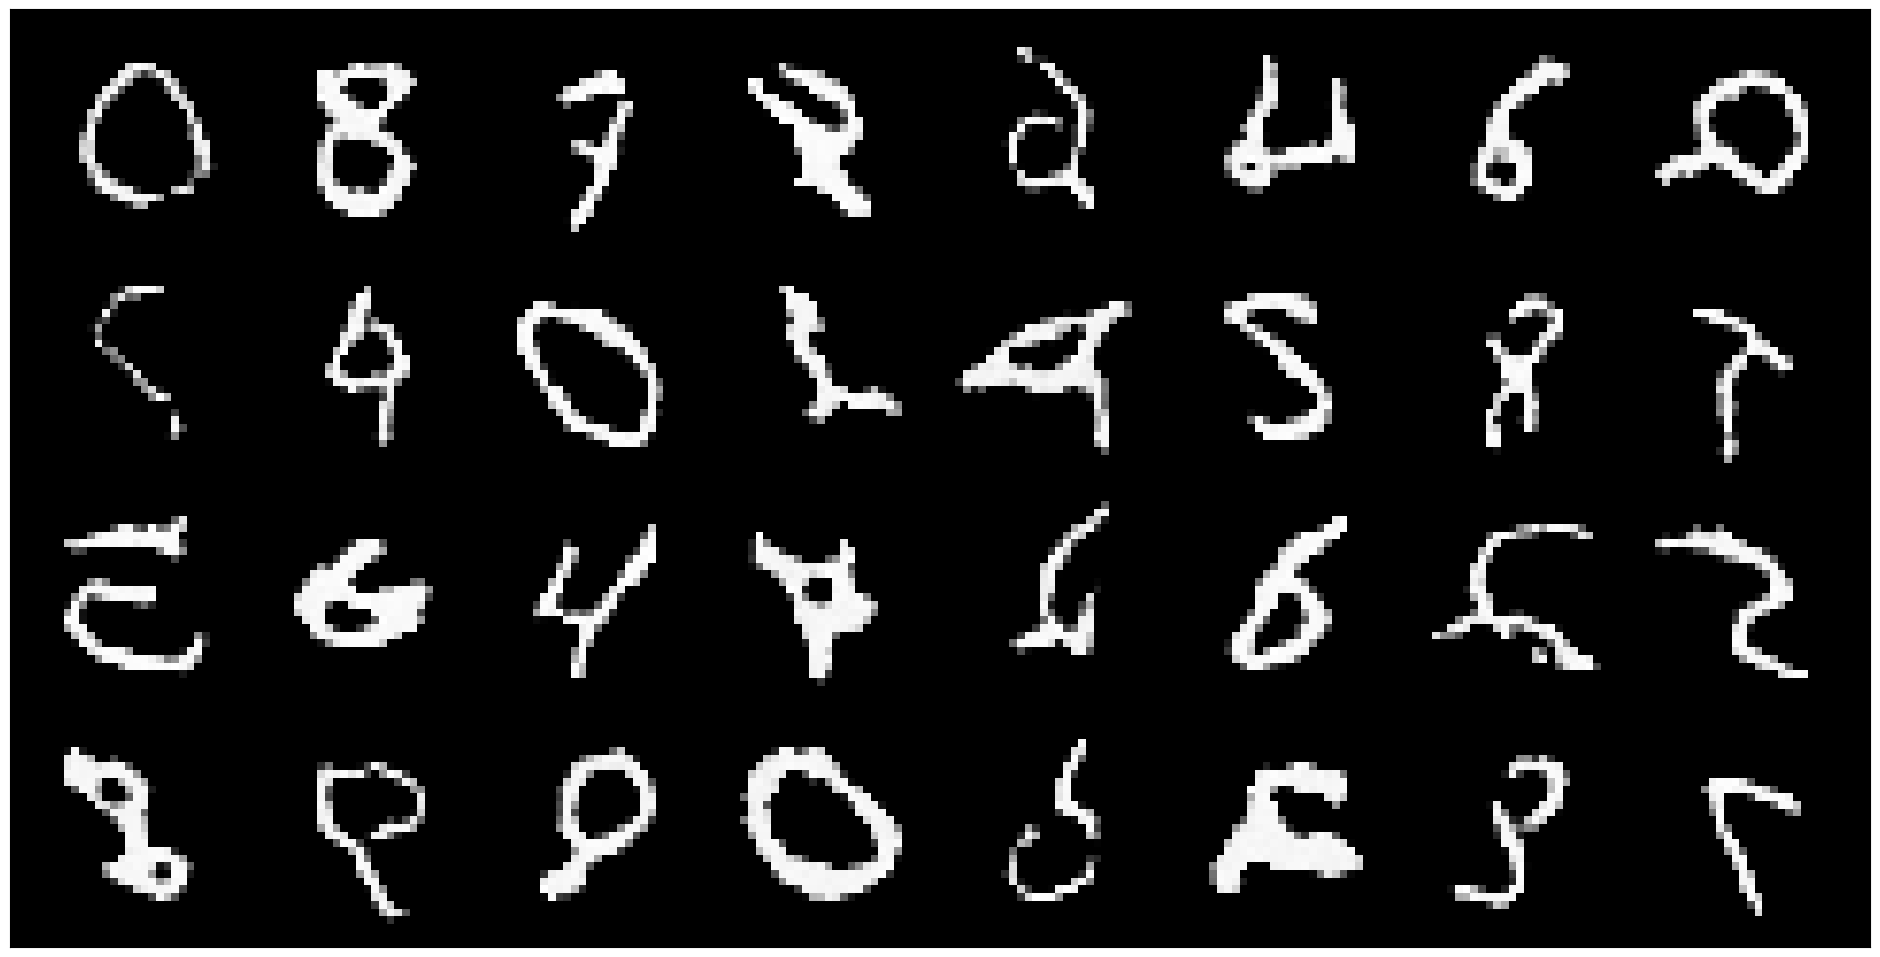

In [ ]:
with torch.no_grad():
  pure_noise = torch.rand([64,1,28,28]).to(device)
  sample_data = sample(diffusion_model, pure_noise, image_size=image_size, timestep=800,  batch_size=BATCH_SIZE, channels=1)
  show_batch(sample_data[-1].cpu().detach())

# Discriminator
In this section is implemented the discriminator model that is based on a VIT architecture. The aim of this model is distinguish between real images and generated images, so this is a binary classification problem.
The architecture is inspired by the paper Dosovitskiy et al (2021) (https://arxiv.org/pdf/2010.11929.pdf) but adapted to the problem of binary classification.


The pretraining procedure is done as in an adversarial network, giving in input real images and fake images generated by the pretrained diffusion model. The model is teached to distinguish between the real images and the fake ones.


<p align="center">
    <img src="https://kikaben.com/understanding-generative-adversarial-networks/images/thumbnail.png" width="600" />
</p>

##ViT

In [16]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor
from einops import repeat


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size,  emb_size = 64):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size)
        )
        self.linear= nn.Linear(patch_size * patch_size * in_channels, emb_size).to(device)

    def forward(self, x):
        x = self.projection(x)
        x = self.linear(x)
        return x


In [17]:
class DiscResidual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn=fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


class DiscPreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


In [18]:
class DiscAttention(nn.Module):
  def __init__(self, emb_dim, num_heads):
    super(DiscAttention, self).__init__()
    self.emb_dim=emb_dim
    self.num_heads = num_heads

    self.attention = nn.MultiheadAttention(self.emb_dim, self.num_heads, dropout=0.1)

    self.q = nn.Linear(emb_dim, emb_dim)
    self.k = nn.Linear(emb_dim, emb_dim)
    self.v = nn.Linear(emb_dim, emb_dim)

  def forward(self, x):
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)
    attention, attention_weights = self.attention(q, k, v)
    return attention

In [19]:
class ViT(nn.Module):
  def __init__(self, emb_dim, hidden_dim, out_dim, channels, input_channels=1, patch_size = 7,  n_layers = 3,  img_size=28, dropout=0.1, num_heads = 8):
    super(ViT, self).__init__()
    self.emb_dim = emb_dim
    self.num_heads = num_heads
    self.hidden_dim = hidden_dim
    self.dropout = dropout
    self.channels = channels
    self.img_width = img_size
    self.img_height = img_size
    self.n_layers = n_layers

    self.patch_embedding = PatchEmbedding(channels, patch_size= patch_size,  emb_size = emb_dim)

    # Learnable params
    num_patches = (img_size // patch_size) ** 2
    self.positional_emb = nn.Parameter(torch.randn(emb_dim, num_patches + 1, emb_dim))
    self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

    self.layers = nn.ModuleList([])
    for _ in range(n_layers):
      block = nn.Sequential(

          DiscResidual(DiscPreNorm(emb_dim, DiscAttention(emb_dim, num_heads))),

          DiscResidual(DiscPreNorm(emb_dim, nn.Sequential(nn.Linear(emb_dim, hidden_dim),
                                                  nn.LeakyReLU(),
                                                  nn.Dropout(dropout),
                                                  nn.Linear(hidden_dim, emb_dim),
                                                  nn.Dropout(dropout)
                                              )))
      )
      self.layers.append(block)

    self.classification_head = nn.Sequential(nn.LayerNorm(emb_dim* (num_patches + 1)), nn.Linear(emb_dim* (num_patches + 1), out_dim))
    self.sigmoid = nn.Sigmoid()
    self.projection = nn.Sequential(
            Rearrange('b h p -> b (h p)')
        )

  def forward(self, batch):
      x = self.patch_embedding(batch)
      b, n, _ = x.shape

      # Add cls token to inputs
      cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
      x = torch.cat([cls_tokens, x], dim=1)
      x += self.positional_emb[:, :(n+1),:]
      for layer in self.layers:
        x = layer(x)
      x = self.projection(x)
      return self.sigmoid(self.classification_head(x[:, :]))

losses = []
discriminator_model = ViT(64, 512, 1, 1).to(device)

##Training

In [ ]:
num_epochs=5
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=1e-4)

for epoch in range(num_epochs):

    for step, batch in enumerate(dataloader):

        if step ==10:
          break

        optimizer.zero_grad()

        t = torch.randint(0, timesteps, (batch[0].shape[0],), device=device).long().to(device)

        noise=torch.randn_like(batch[0]).to(device) #crea rumore con la stessa dimensione del batch
        x_noisy = q_sample(x_start=batch[0].to(device), t=t, noise=noise)
        predicted_noise = diffusion_model(x_noisy[0], t)
        with torch.no_grad():
          fake_data = sample( diffusion_model, x_noisy[0], image_size, timestep=timesteps,  batch_size=BATCH_SIZE, channels=channels)

        # Preparazione dei dati
        real_data = batch

        # Etichette per esempi reali e falsi
        real_labels = torch.ones(BATCH_SIZE, 1).to(device)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)
        if real_data[0].shape[0] == BATCH_SIZE:
          output_real = discriminator_model(real_data[0].to(device))
          loss_real = criterion(output_real, real_labels)
        else:
          break

        # Forward pass per esempi falsi
        output_fake = discriminator_model(fake_data[-1].detach())  # Detach per evitare di propagare il gradiente al generatore
        loss_fake = criterion(output_fake, fake_labels)

        # Calcolo totale della loss
        total_loss = loss_real + loss_fake
        print(loss_real)
        print(loss_fake)
        print("Epoch: " + str(epoch)+ "   Loss:", total_loss)

        total_loss.backward()
        optimizer.step()

tensor(0.5816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.8898, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0   Loss: tensor(1.4714, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6474, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7979, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0   Loss: tensor(1.4453, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6962, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0   Loss: tensor(1.4216, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7494, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6622, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0   Loss: tensor(1.4116, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>

In [ ]:
#path = '/content/drive/MyDrive/discriminator_model.pth'

# Salva il modello
#torch.save(discriminator_model.state_dict(), path)

# ADD Training

The training procedure is splitted in 3 main different part.

The first part is a pretraining procedure that gives in input to the teacher and to the student model the same noised image in order to pretrain the student and the discriminator.

The second part is the main part in which is implemneted the ADD training procedure. The student take in input the noised image, instead the teacher will take in input the noised output of the student. At the end the two outputs will be compared in the distillation loss and the result of the ADD-student denoise will pass in the Discriminator that will compute the discriminator loss. The two losses will be summed up and the resulting total loss will be backpropagated and the parameters of the model will be updated.

The third and last part consist in improving the performance of the student. In this part the student take in input pure noise ( a random vector of dimension [64,1,28,28] ), the teacher instead take in input a noised version of the student's output. In this way the teacher will teach to the student how to denoise improving the performance during test.

The discriminator model is updated every 10 steps in order to avoid that the discriminator learn too fast compared to the generator

Instead of the 4 step proposed in the original paper i decided to use 5 steps in order to reduce the training time.

For the teacher instead i used 400 denoise step because i have seen that the results were acceptably good.

The  distillation weighting factor value is the one proposed in the paper l = 2.5.

I decided to insert a regularization term to avoid mode collapse in the third trainng phase because i have seen that without this mode collapse occurs very often.

The input size is fixed to 28 x 28 x 1.

I decided to set the student steps to 6, because I have seen that reach the 4 steps as in the paper requires a lot of steps more and due to the google colab's limitation i prefered to increase the steps.

The number of teacher steps has been set to 400 because i have seen that was enough for a good reconstruction of the image. I also have seen that with a greater number of iteration the image will be distorted.

In [ ]:
image_size = 28
channels = 1
batch_size = 64
student_timesteps = 6
teacher_timesteps= 400

disc_loss = nn.BCELoss()
disc_loss2 = nn.BCELoss()
dis_loss = nn.MSELoss()
l = 2.5
regularization_term = 2

In this section we import the pretrained models.

The teacher model have been set to evaluation mode, instead the discriminator and the student model have been set to train mode.

In [ ]:
# path to load the pretrained models (First you have to download the models from github)
diffusion_path = '../Neural_Network/models/models/diffusion_model_last_version.pth'
discriminator_path = '../Neural_Network/models/models/discriminator_model_last_version.pth'
student_path = '../Neural_Network/models/models/student_model_last_version.pth'


# Load the teacher_model
teacher_model = Unet(  dim=image_size,  channels=channels,  dim_mults=(1, 2, 4,))
teacher_model.load_state_dict(torch.load(diffusion_path))
teacher_model.eval()
teacher_model.to(device)

# Load the discriminator_model
discriminator_model = ViT(64, 512, 1, 1)
discriminator_model.load_state_dict(torch.load(discriminator_path))
discriminator_model.train()
discriminator_model.to(device)

# Load the student_model
student_model = Unet( dim=image_size, channels=channels, dim_mults=(1, 2, 4,))
#if you want to restart the train from scratch set this path to diffusion_path
student_model.load_state_dict(torch.load(student_path))
student_model.train()
student_model.to(device)

##Pretrain

Epoch: 0  Adversarial Loss:tensor(2.5608, device='cuda:0', grad_fn=<AddBackward0>)


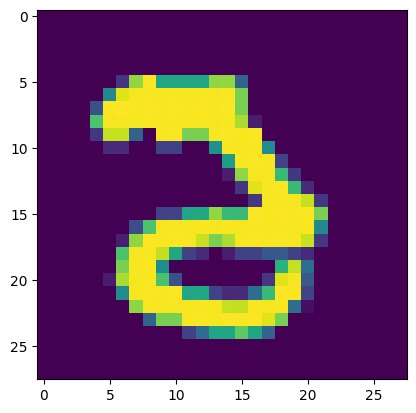

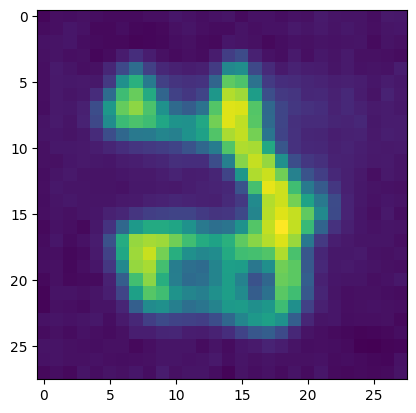

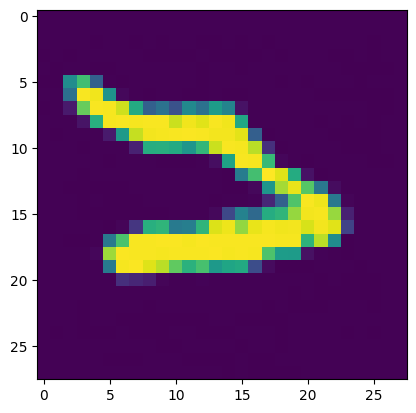

Epoch: 0   Loss: tensor(0.8100, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1564, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.4189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.5608, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0.7960, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1526, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.4145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.5608, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0.7677, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1439, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.4078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.5608, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0

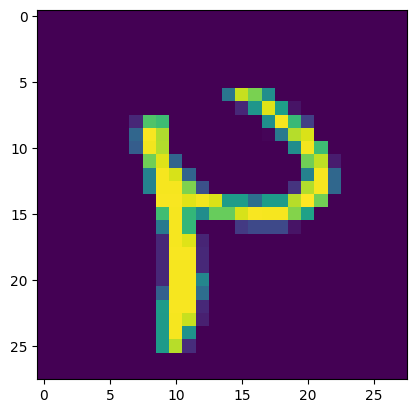

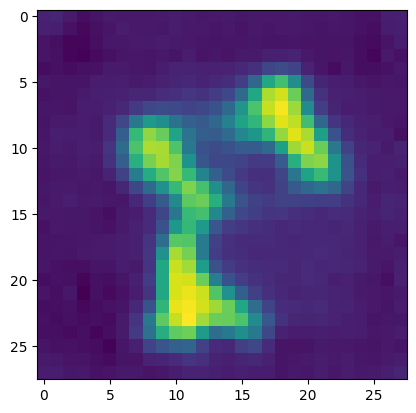

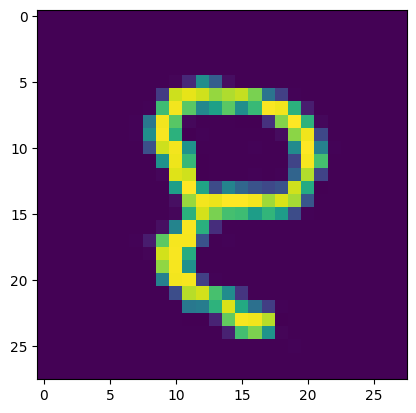

Epoch: 0   Loss: tensor(0.5421, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1591, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1443, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(1.5152, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0.5395, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1580, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1445, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(1.5152, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0.5493, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1628, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1422, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(1.5152, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0

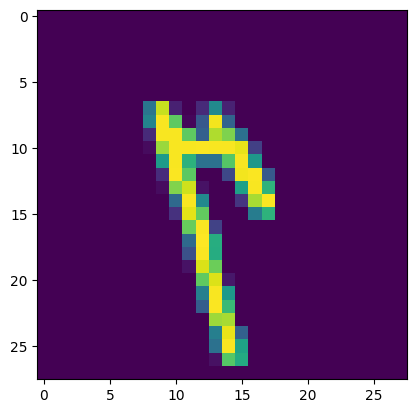

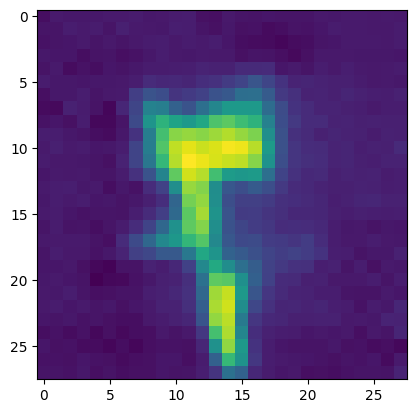

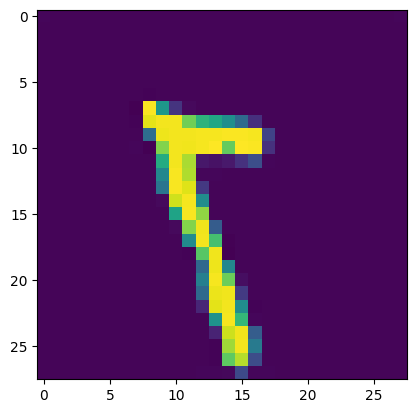

Epoch: 0   Loss: tensor(0.4206, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1457, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0563, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.1761, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0.4667, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1637, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0574, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.1761, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0.4503, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1582, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0547, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.1761, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0

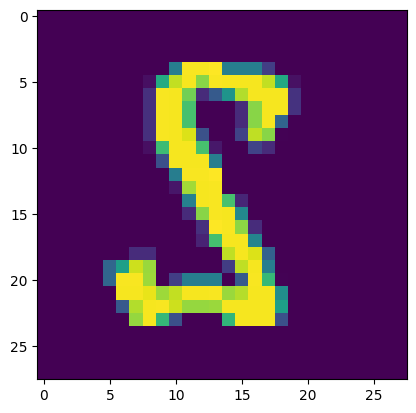

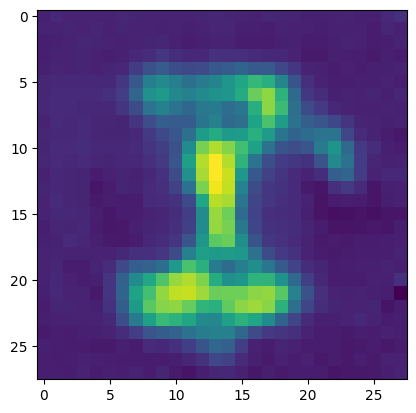

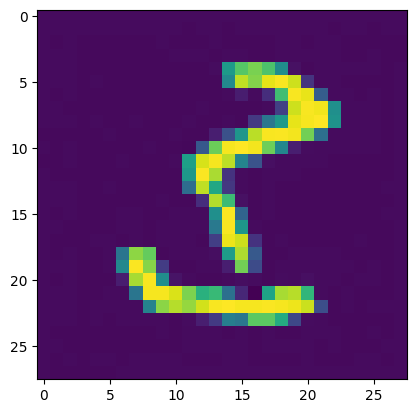

Epoch: 0   Loss: tensor(0.4088, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1510, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0314, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.9659, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0.4407, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1635, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0319, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.9659, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0.4107, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1513, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0325, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.9659, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0

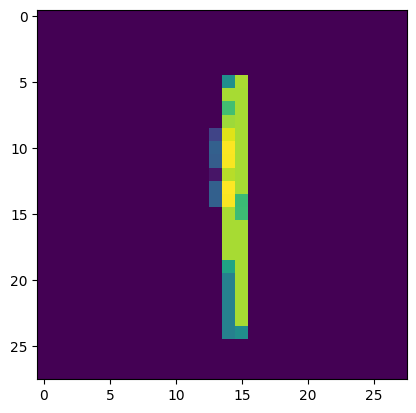

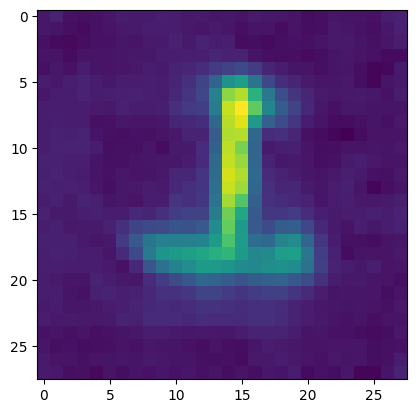

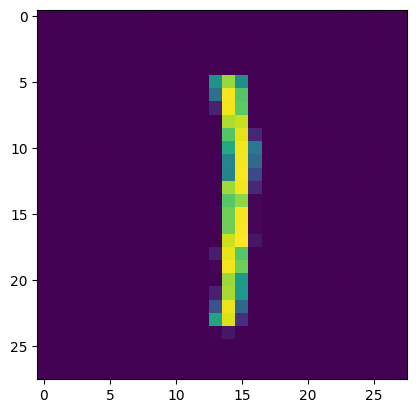

Epoch: 0   Loss: tensor(0.3947, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1477, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(3.5120, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0.3980, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1490, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(3.5120, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0.3983, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1492, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(3.5120, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0

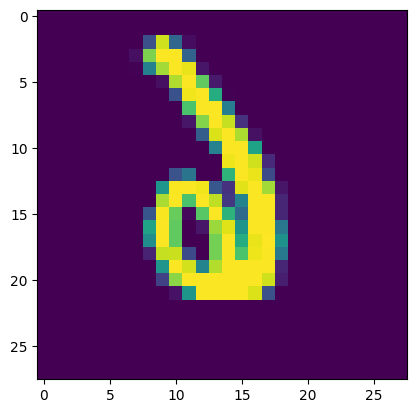

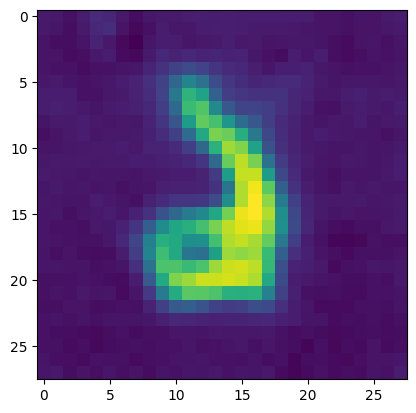

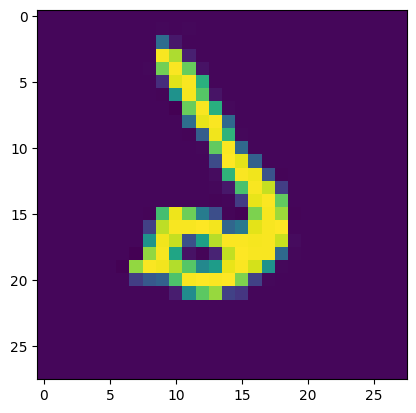

Epoch: 0   Loss: tensor(0.3937, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1472, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0257, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(3.7176, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0.4293, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1612, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0264, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(3.7176, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0.4132, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1548, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0261, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(3.7176, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0

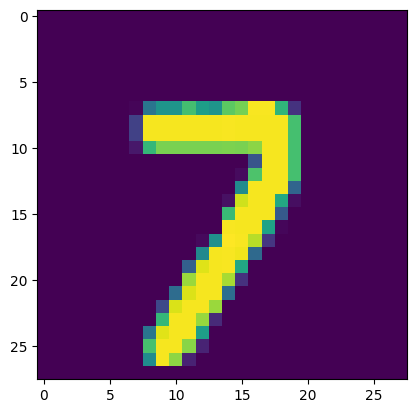

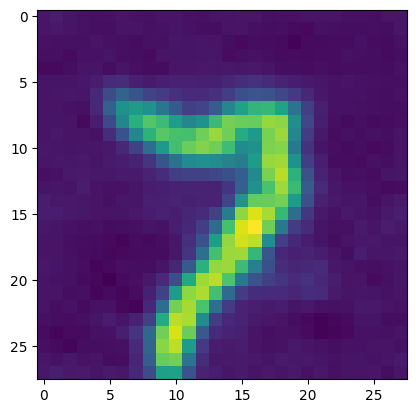

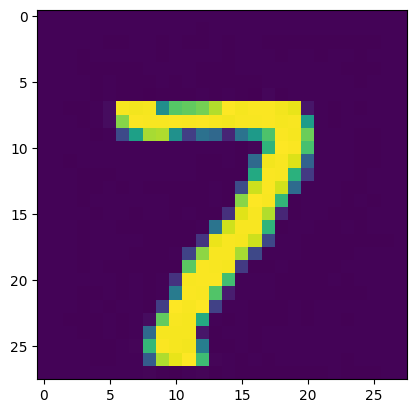

Epoch: 0   Loss: tensor(0.4045, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1491, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0318, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(3.7018, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0.4141, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1528, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0320, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(3.7018, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0.3836, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1408, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0316, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(3.7018, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0

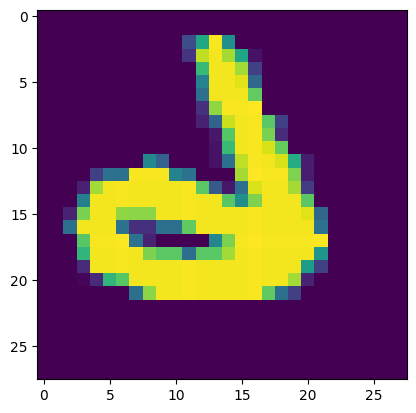

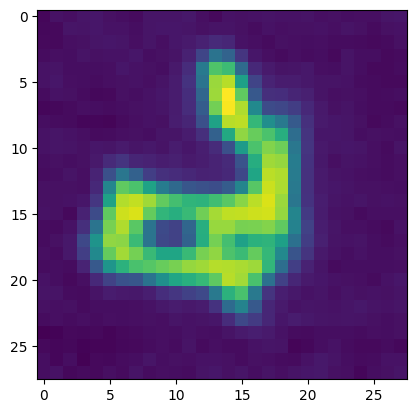

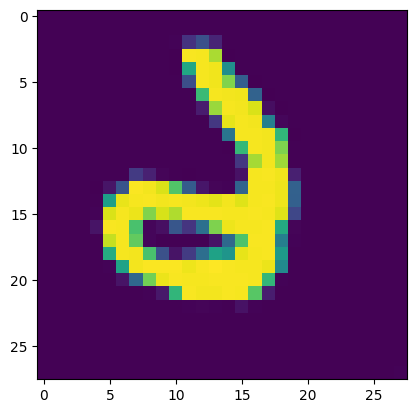

Epoch: 0   Loss: tensor(0.4006, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1426, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0441, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(3.5119, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0.4261, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1531, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0434, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(3.5119, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0.4009, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1426, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0444, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(3.5119, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0

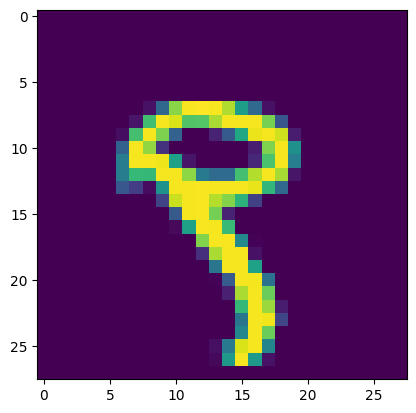

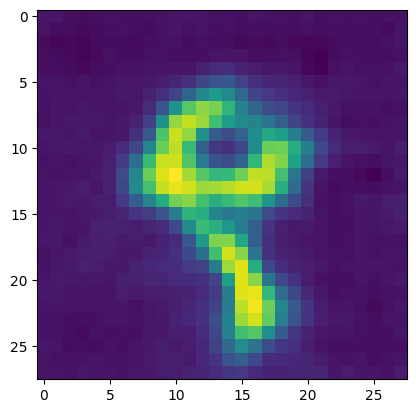

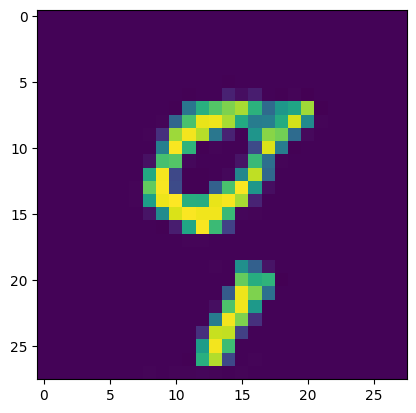

Epoch: 0   Loss: tensor(0.4189, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1409, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0668, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(3.2029, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0.4319, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1462, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0665, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(3.2029, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0.4326, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1454, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0691, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(3.2029, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0

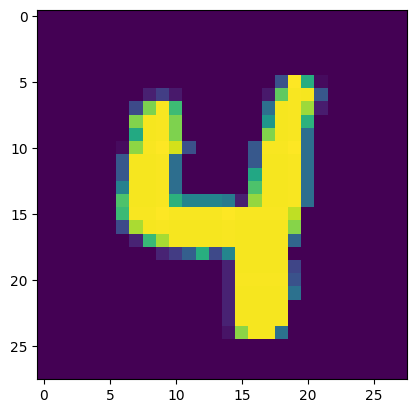

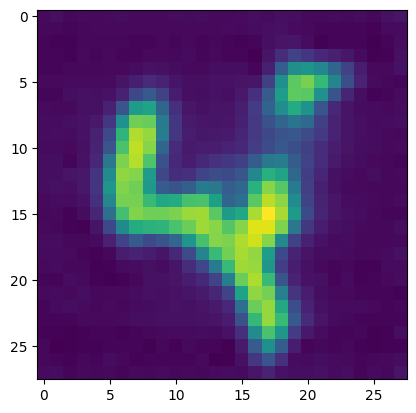

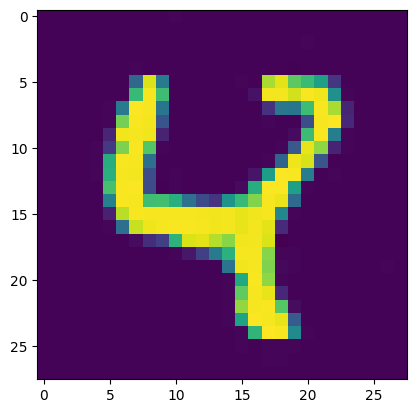

Epoch: 0   Loss: tensor(0.4367, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1331, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.8264, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0.4993, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1579, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.8264, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0.4600, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1420, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.8264, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0   Loss: tensor(0

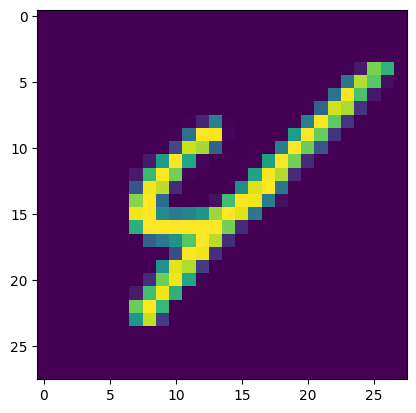

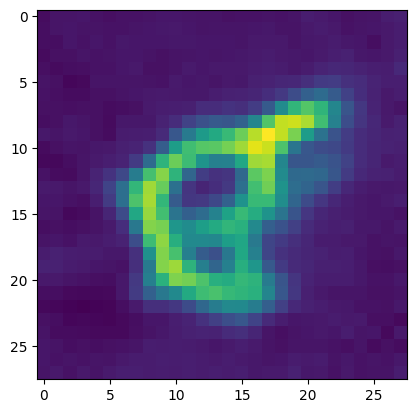

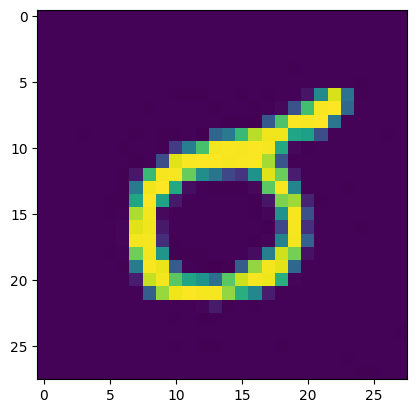

Epoch: 1   Loss: tensor(0.5012, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1414, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1477, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.4108, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0.5114, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1455, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1477, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.4108, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0.5008, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1405, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1495, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.4108, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0

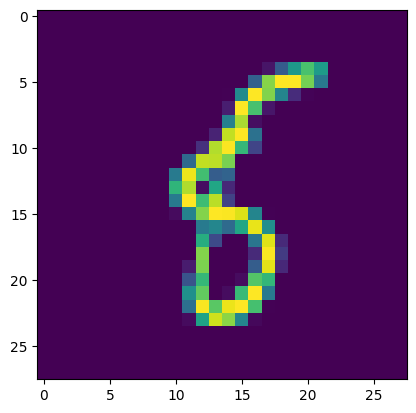

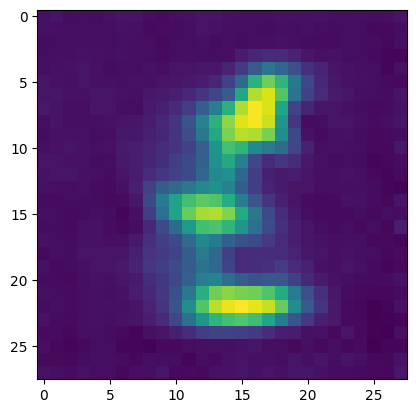

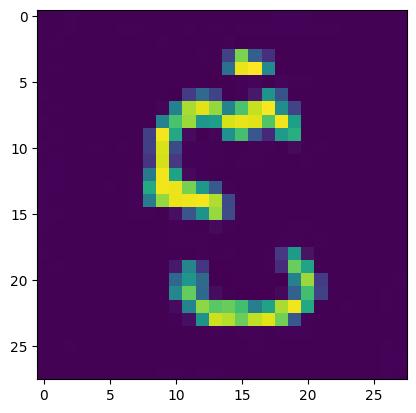

Epoch: 1   Loss: tensor(0.5032, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1357, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1640, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.1358, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0.5090, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1390, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1614, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.1358, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0.4925, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1319, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1627, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.1358, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0

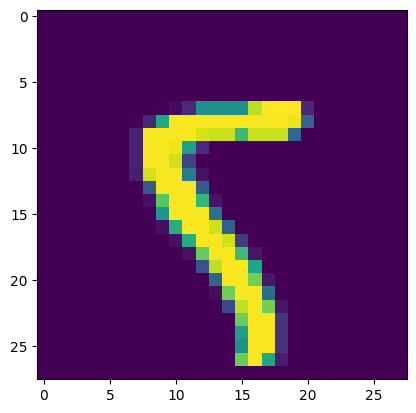

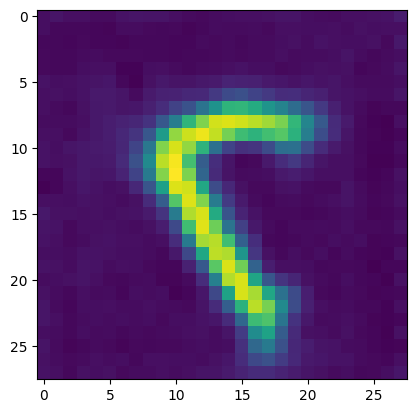

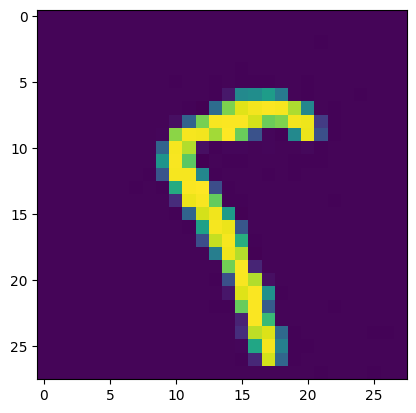

Epoch: 1   Loss: tensor(0.4788, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1337, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1445, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.0775, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0.4897, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1371, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1470, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.0775, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0.4992, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1409, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1470, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.0775, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0

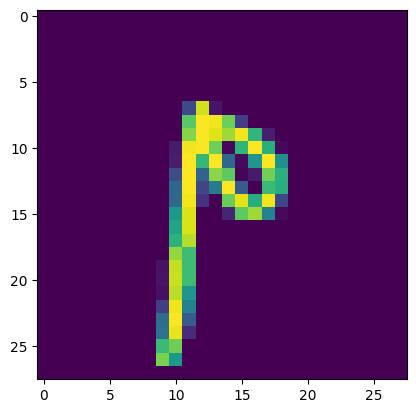

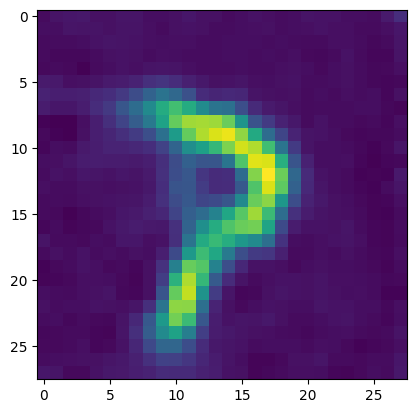

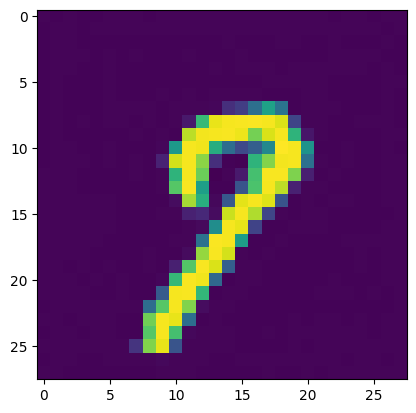

Epoch: 1   Loss: tensor(0.4649, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1383, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1192, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.1407, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0.4730, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1414, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.1407, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0.4575, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1353, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1192, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.1407, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0

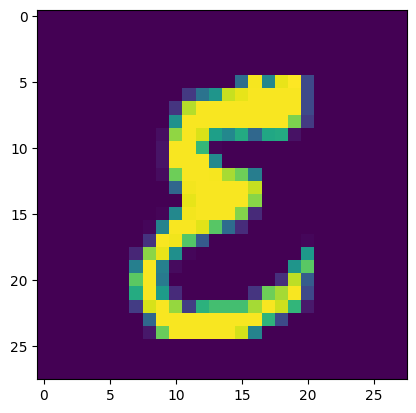

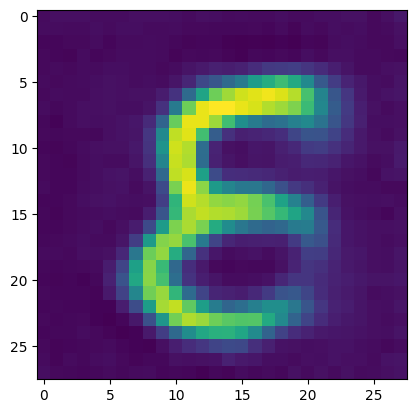

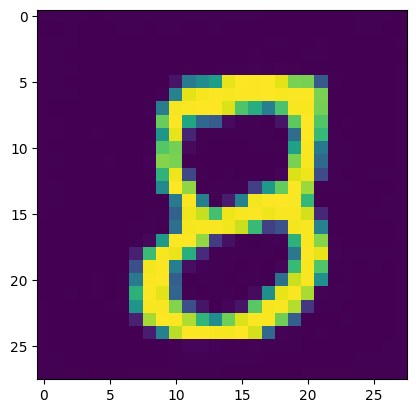

Epoch: 1   Loss: tensor(0.4276, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1349, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0902, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.3094, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0.4372, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1382, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0916, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.3094, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0.4138, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1288, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0918, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.3094, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0

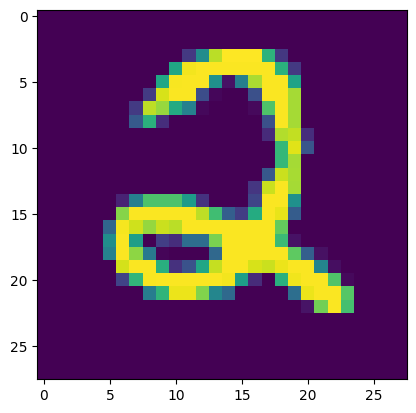

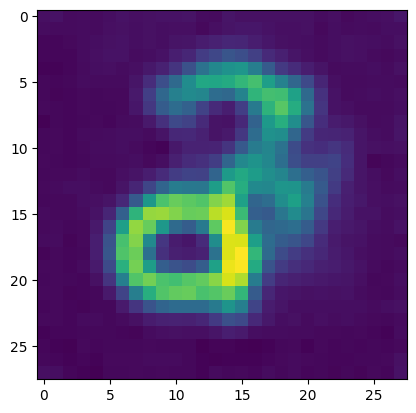

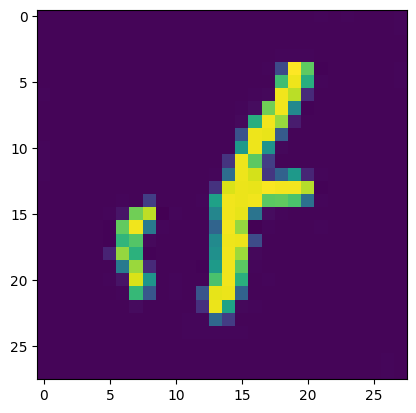

Epoch: 1   Loss: tensor(0.4299, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1432, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0719, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.5417, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0.4273, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1423, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0716, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.5417, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0.4281, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1424, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0721, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.5417, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0

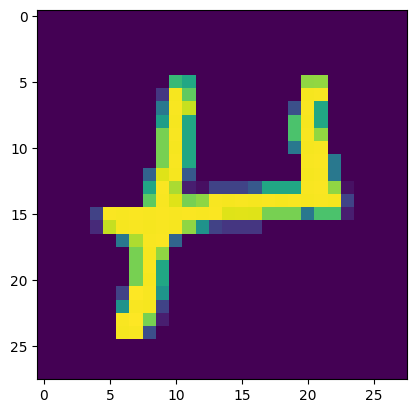

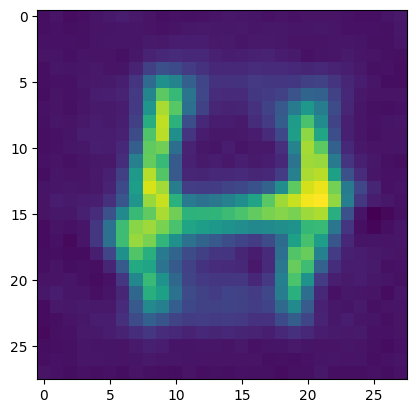

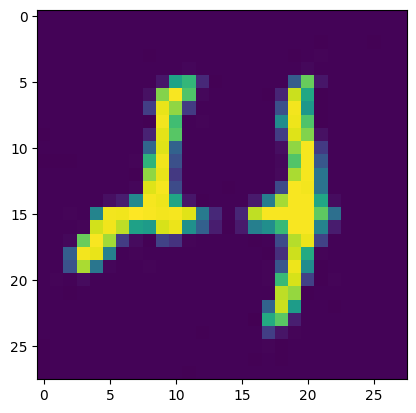

Epoch: 1   Loss: tensor(0.3910, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1325, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0598, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.7328, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0.4014, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1365, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0601, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.7328, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0.3855, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1302, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0600, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.7328, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1   Loss: tensor(0

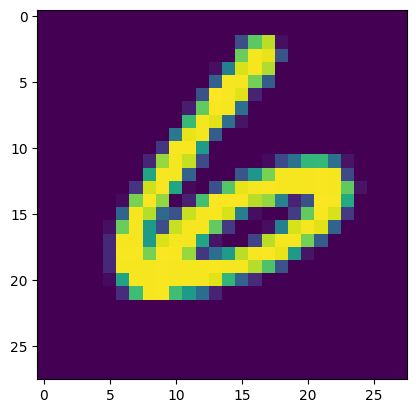

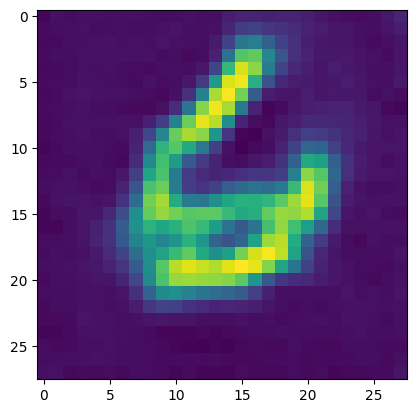

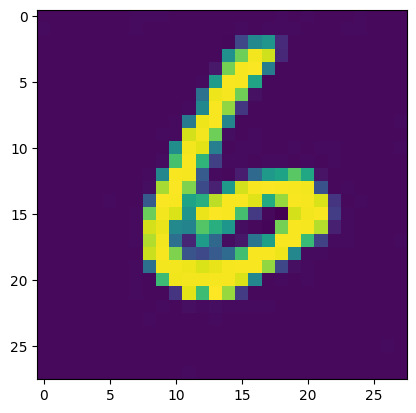

Epoch: 1   Loss: tensor(0.3888, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.1333, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0556, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(2.9080, device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()
epochs = 3

student_optimizer = Adam(student_model.parameters(), lr=1e-3, weight_decay=1e-5)
discriminator_optimizer = Adam(discriminator_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_student = torch.optim.lr_scheduler.ReduceLROnPlateau(student_optimizer, 'min', patience=1, factor=0.1)
scheduler_discriminator = torch.optim.lr_scheduler.ReduceLROnPlateau(discriminator_optimizer, 'min', patience=1, factor=0.1)

losses=[]

for epoch in range(epochs):

    for step, batch in enumerate(dataloader):
      if step == 100:
        break

      student_optimizer.zero_grad()

      batch_size = batch[0].shape[0]
      batch = batch[0].to(device)

      t_student = torch.randint(teacher_timesteps-1, teacher_timesteps, (batch_size,), device=device).long()
      t_teacher = torch.randint(teacher_timesteps-1, teacher_timesteps, (batch_size,), device=device).long()

      noise = torch.randn_like(batch) #crea rumore con la stessa dimensione del batch
      x_noisy_student = q_sample(x_start=batch, t=t_student, noise=noise)

      student_data = sample( student_model, x_noisy_student[0] , image_size, timestep=student_timesteps,  batch_size=batch_size, channels=channels)

      real_labels = torch.ones(batch_size, 1).to(device)
      fake_labels = torch.zeros(batch_size, 1).to(device)

      output_real = discriminator_model(batch)
      loss_real = disc_loss(output_real, real_labels)
      # Forward pass per esempi falsi
      output_fake = discriminator_model(student_data[-1])
      loss_fake = disc_loss(output_fake, fake_labels)

      if step % 10==0:
        # Calcolo totale della loss
        adversarial_loss = loss_real + loss_fake
        adversarial_loss.backward(retain_graph=True)
        discriminator_optimizer.step()
        discriminator_optimizer.zero_grad()

      print("Epoch: " + str(epoch) , " Adversarial Loss:" + str(adversarial_loss) )

      output_fake = discriminator_model(student_data[-1])
      loss_fake = disc_loss(output_fake, real_labels)

      x_noisy_teacher = q_sample(x_start=student_data[-1], t=t_teacher, noise=noise)

      with torch.no_grad():

        teacher_data = sample( teacher_model, x_noisy_student[0], image_size, timestep=teacher_timesteps,  batch_size=batch_size, channels=channels)

      if step % 10 == 0:
        #show the results
        random_index = random.randint(0, 63)
        image_data0 = batch[random_index].cpu().numpy().reshape(image_size, image_size, channels)
        image_data1 = student_data[-1][random_index].cpu().detach().numpy().reshape(image_size, image_size, channels)
        image_data3 = teacher_data[-1][random_index].cpu().numpy().reshape(image_size, image_size, channels)
        plt.imshow(image_data0)
        plt.show()
        plt.imshow(image_data1)
        plt.show()
        plt.imshow(image_data3)
        plt.show()

      distill_loss = dis_loss(teacher_data[-1] , student_data[-1])
      loss = l*distill_loss + loss_fake
      losses.append(loss)

      print("Epoch: " + str(epoch) + "   Loss:", str(loss), "  Distillation Loss:" + str(distill_loss), " Adversarial Loss:" + str(loss_fake) )

      loss.backward()
      student_optimizer.step()

    scheduler_student.step(loss)
    scheduler_discriminator.step(adversarial_loss)

## ADD train

Epoch: 0  Adversarial Loss:tensor(2.3896, device='cuda:0', grad_fn=<AddBackward0>)


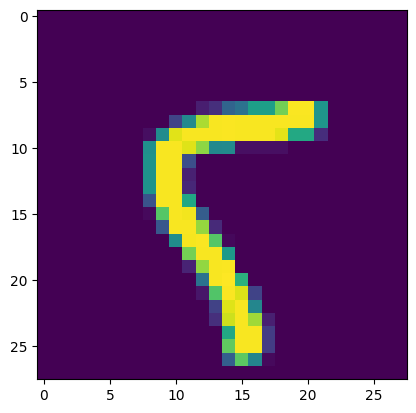

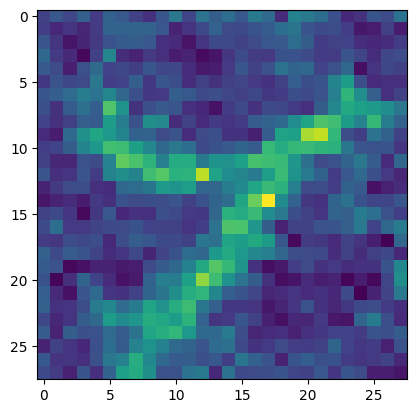

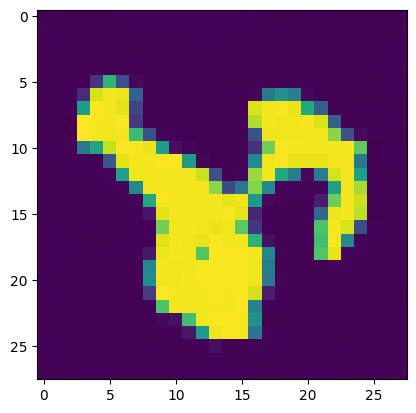

Epoch: 0  Total Loss: tensor(1.2156, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2763, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.5249, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.3896, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0  Total Loss: tensor(1.2507, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2916, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.5216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.3896, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0  Total Loss: tensor(1.2655, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2977, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.5212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.3896, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 0  

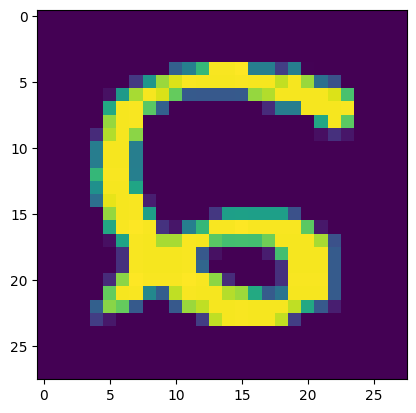

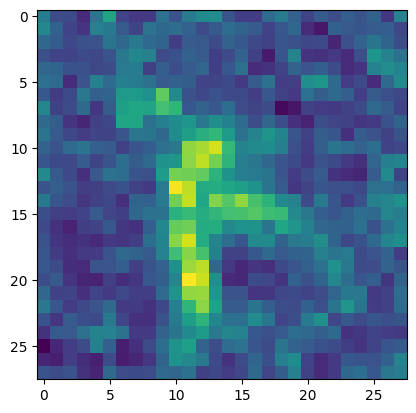

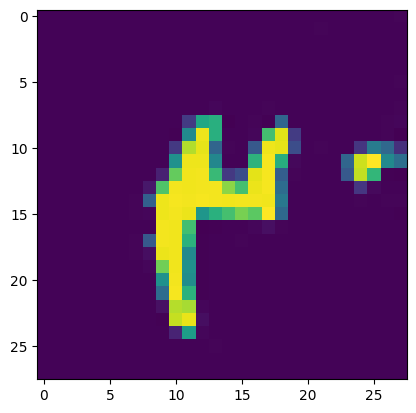

Epoch: 1  Total Loss: tensor(0.8966, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2682, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.2261, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(1.4225, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1  Total Loss: tensor(0.9170, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2781, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.2217, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(1.4225, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1  Total Loss: tensor(0.9488, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2930, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.2163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(1.4225, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 1  

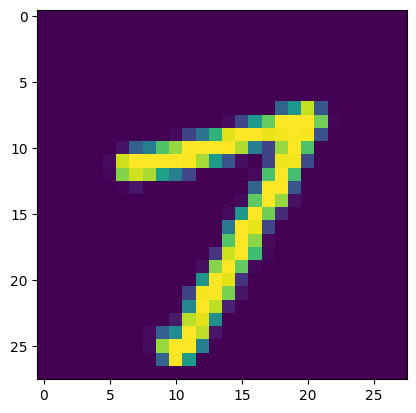

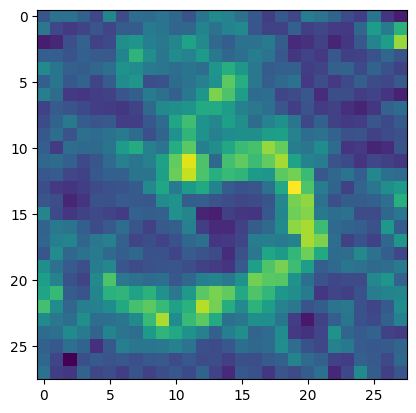

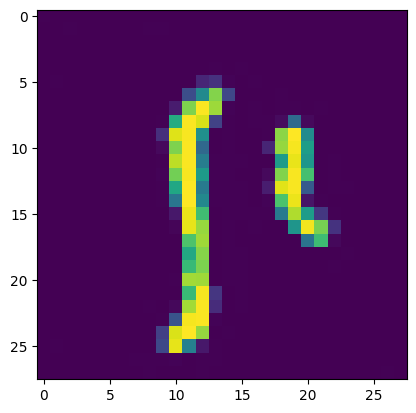

Epoch: 2  Total Loss: tensor(0.7703, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2724, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0892, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(1.8563, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 2  Total Loss: tensor(0.7640, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2696, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0900, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(1.8563, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 2  Total Loss: tensor(0.7678, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2724, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(1.8563, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 2  

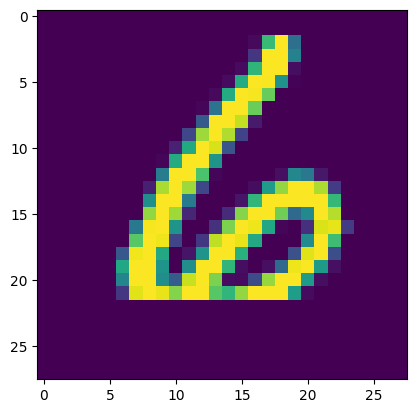

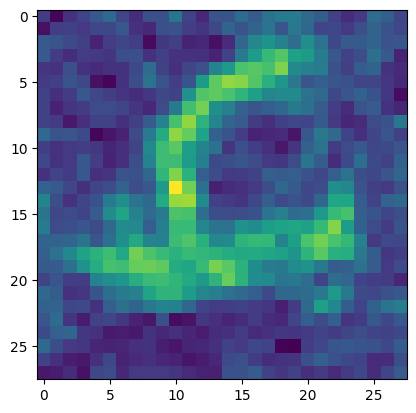

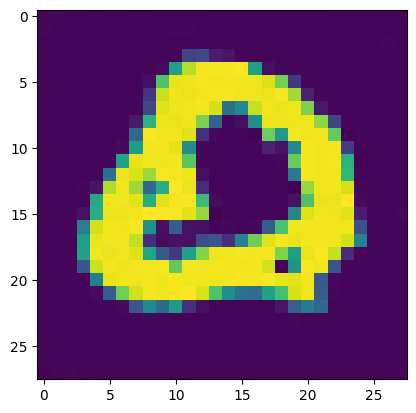

Epoch: 3  Total Loss: tensor(0.6290, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2336, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0451, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(2.5945, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 3  Total Loss: tensor(0.7203, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2702, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0448, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(2.5945, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 3  Total Loss: tensor(0.6695, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2495, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0457, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(2.5945, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 3  

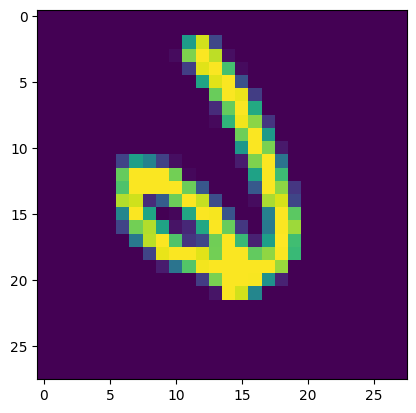

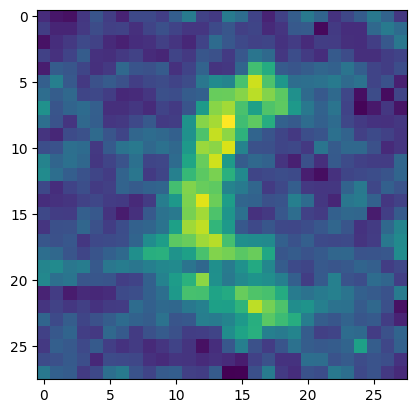

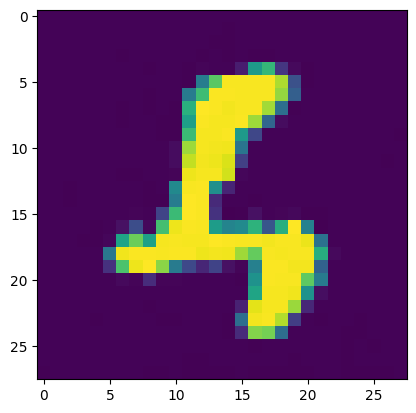

Epoch: 4  Total Loss: tensor(0.6744, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2525, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0432, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 4  Adversarial Loss:tensor(3.1942, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 4  Total Loss: tensor(0.7105, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2666, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0441, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 4  Adversarial Loss:tensor(3.1942, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 4  Total Loss: tensor(0.6803, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2543, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0446, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 4  Adversarial Loss:tensor(3.1942, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 4  

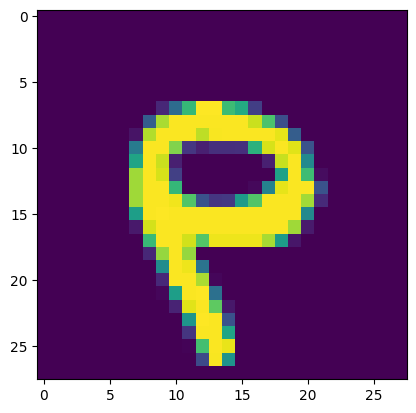

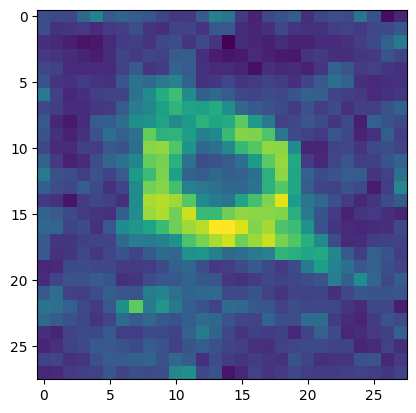

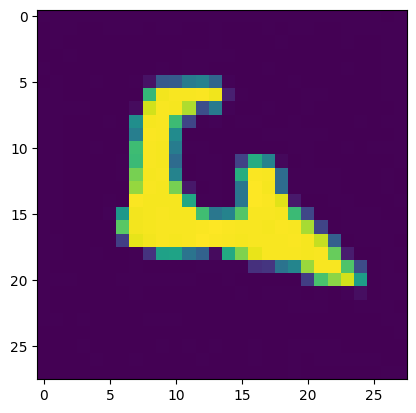

Epoch: 5  Total Loss: tensor(0.6821, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2552, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0442, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 5  Adversarial Loss:tensor(3.1805, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 5  Total Loss: tensor(0.6885, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2575, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0448, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 5  Adversarial Loss:tensor(3.1805, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 5  Total Loss: tensor(0.7020, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2632, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0438, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 5  Adversarial Loss:tensor(3.1805, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 5  

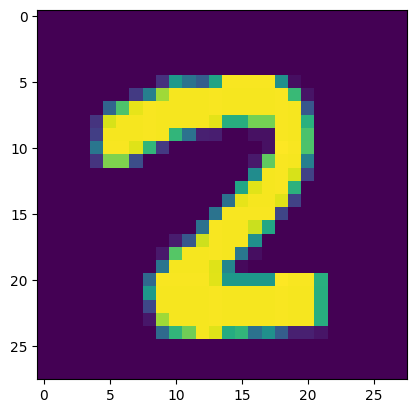

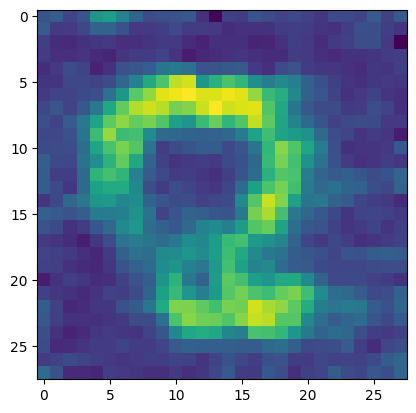

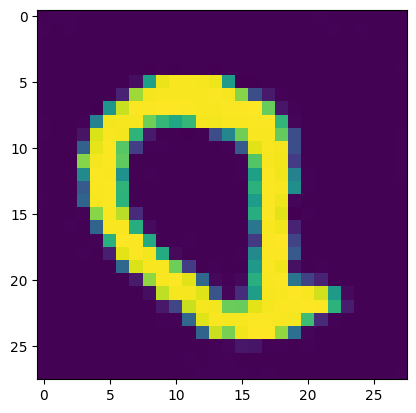

Epoch: 6  Total Loss: tensor(0.6368, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2371, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0441, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 6  Adversarial Loss:tensor(3.2112, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 6  Total Loss: tensor(0.6964, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2607, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0448, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 6  Adversarial Loss:tensor(3.2112, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 6  Total Loss: tensor(0.6644, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2478, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0447, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 6  Adversarial Loss:tensor(3.2112, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 6  

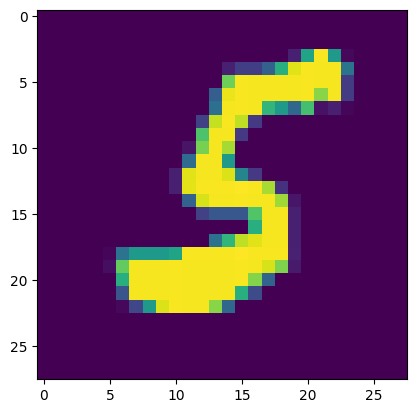

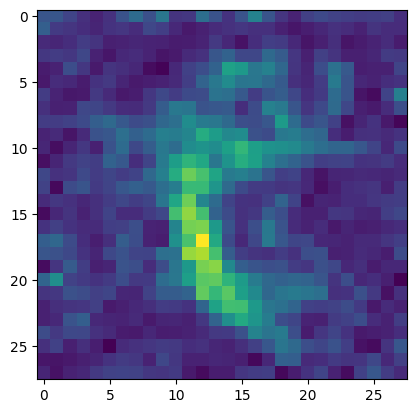

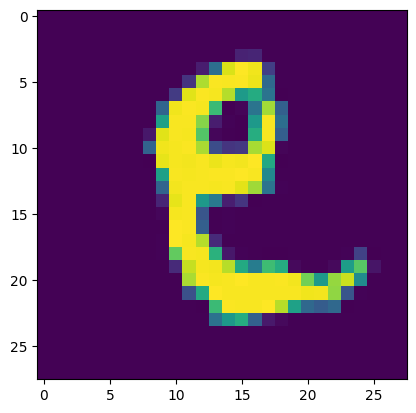

Epoch: 7  Total Loss: tensor(0.6741, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2519, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0443, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 7  Adversarial Loss:tensor(3.2047, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 7  Total Loss: tensor(0.6623, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2470, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0448, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 7  Adversarial Loss:tensor(3.2047, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 7  Total Loss: tensor(0.6624, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2475, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0438, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 7  Adversarial Loss:tensor(3.2047, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 7  

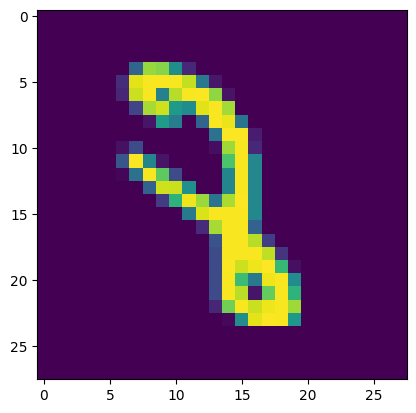

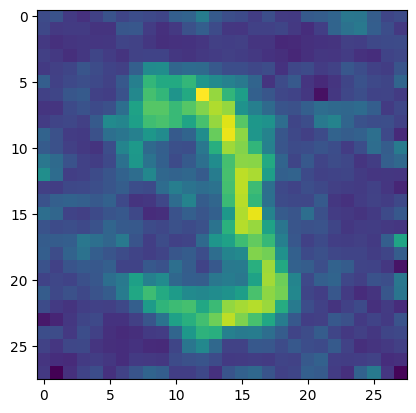

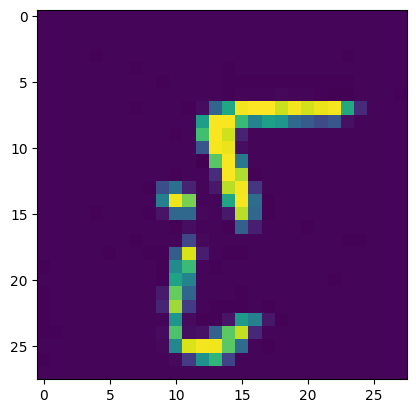

Epoch: 8  Total Loss: tensor(0.6317, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2351, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0438, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 8  Adversarial Loss:tensor(3.2146, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 8  Total Loss: tensor(0.6066, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2253, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0434, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 8  Adversarial Loss:tensor(3.2146, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 8  Total Loss: tensor(0.6327, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2359, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0429, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 8  Adversarial Loss:tensor(3.2146, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 8  

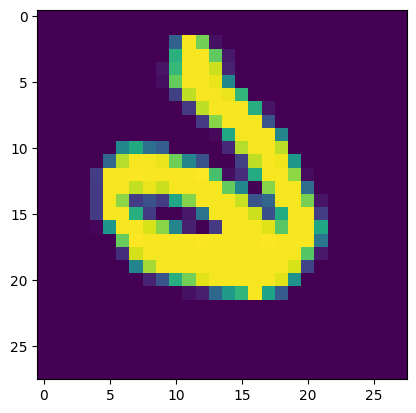

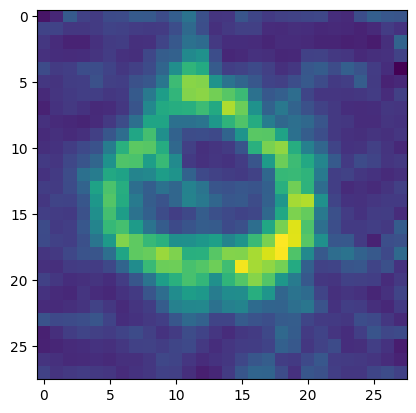

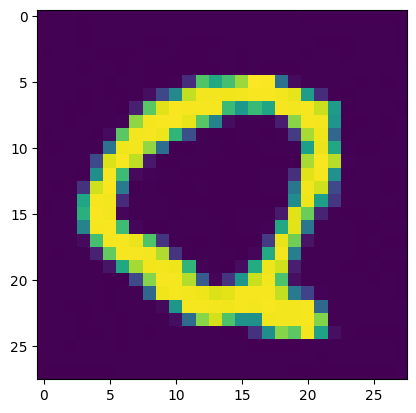

Epoch: 9  Total Loss: tensor(0.6594, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2460, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0443, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 9  Adversarial Loss:tensor(3.1951, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 9  Total Loss: tensor(0.6562, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2451, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0434, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 9  Adversarial Loss:tensor(3.1951, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 9  Total Loss: tensor(0.6645, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2485, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0433, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 9  Adversarial Loss:tensor(3.1951, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 9  

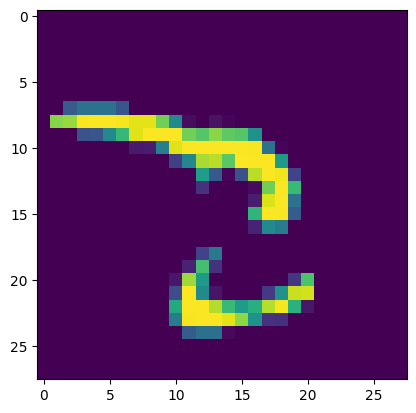

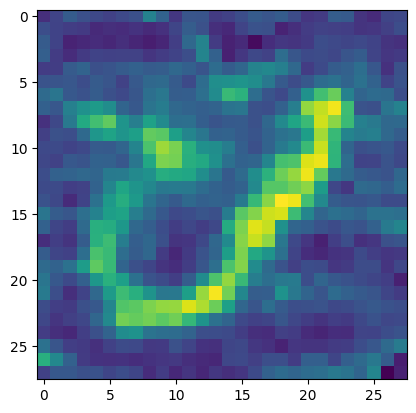

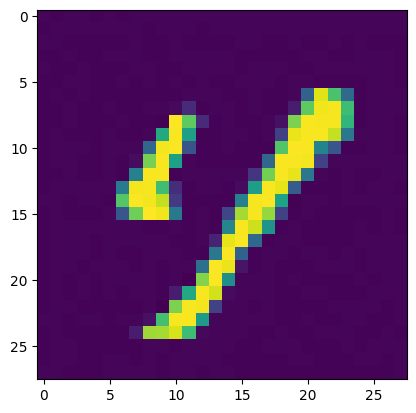

Epoch: 10  Total Loss: tensor(0.6338, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2364, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0429, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 10  Adversarial Loss:tensor(3.2288, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 10  Total Loss: tensor(0.6448, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2408, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0428, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 10  Adversarial Loss:tensor(3.2288, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 10  Total Loss: tensor(0.6488, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2424, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0427, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 10  Adversarial Loss:tensor(3.2288, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

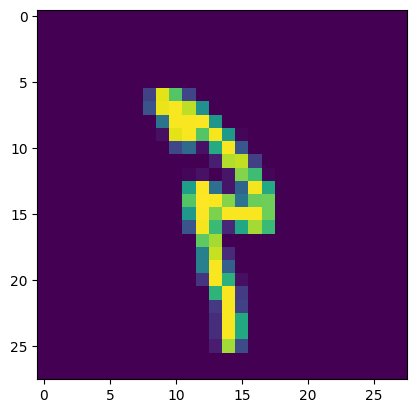

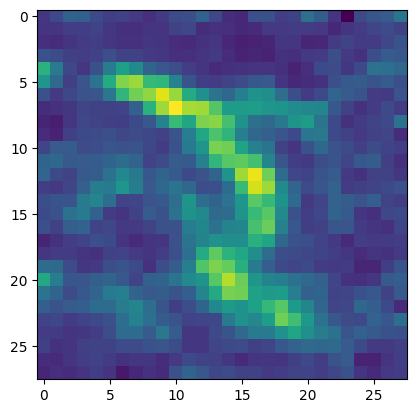

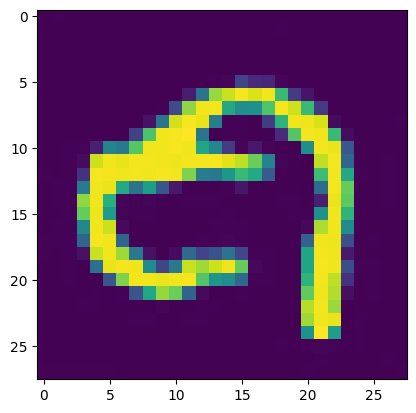

Epoch: 11  Total Loss: tensor(0.6596, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2468, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0426, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 11  Adversarial Loss:tensor(3.2175, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 11  Total Loss: tensor(0.6231, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2317, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0439, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 11  Adversarial Loss:tensor(3.2175, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 11  Total Loss: tensor(0.6653, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2484, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0442, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 11  Adversarial Loss:tensor(3.2175, device='cuda:0', grad_fn=<AddBackward0>)
Epoc

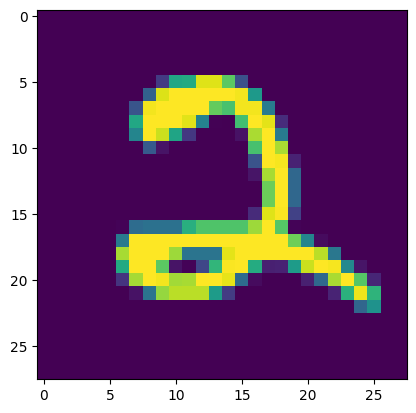

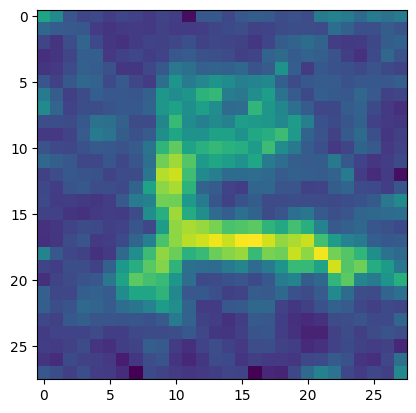

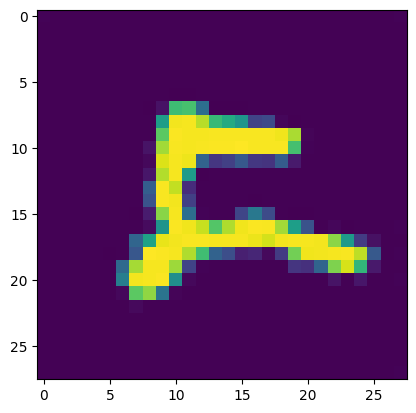

Epoch: 12  Total Loss: tensor(0.6256, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.2324, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0447, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 12  Adversarial Loss:tensor(3.1854, device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()
epochs = 15

student_optimizer = Adam(student_model.parameters(), lr=1e-5, weight_decay=1e-5)
discriminator_optimizer = Adam(discriminator_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_student = torch.optim.lr_scheduler.ReduceLROnPlateau(student_optimizer, 'min', patience=1, factor=0.5)
scheduler_discriminator = torch.optim.lr_scheduler.ReduceLROnPlateau(discriminator_optimizer, 'min', patience=1, factor=0.05)

losses=[]

for epoch in range(epochs):

    for step, batch in enumerate(dataloader):
      if step == 100:
        break

      student_optimizer.zero_grad()

      batch_size = batch[0].shape[0]
      batch = batch[0].to(device)

      t_student = torch.randint(teacher_timesteps, teacher_timesteps*2, (batch_size,), device=device).long()
      t_teacher = torch.randint(teacher_timesteps, teacher_timesteps*2, (batch_size,), device=device).long()

      #t_student = torch.randint(teacher_timesteps*2-1, teacher_timesteps*2, (batch_size,), device=device).long()
      #t_teacher = torch.randint(0, teacher_timesteps*2, (batch_size,), device=device).long()

      noise = torch.randn_like(batch)
      x_noisy_student = q_sample(x_start=batch, t=t_student, noise=noise)

      student_data = sample( student_model, x_noisy_student[0] , image_size, timestep=student_timesteps,  batch_size=batch_size, channels=channels)

      real_labels = torch.ones(batch_size, 1).to(device)
      fake_labels = torch.zeros(batch_size, 1).to(device)

      output_real = discriminator_model(batch)
      loss_real = disc_loss(output_real, real_labels)
      # Forward pass per esempi falsi
      output_fake = discriminator_model(student_data[-1])
      loss_fake = disc_loss(output_fake, fake_labels)

      if step % 10==0:
        # Calcolo totale della loss
        adversarial_loss = loss_real + loss_fake
        adversarial_loss.backward(retain_graph=True)
        discriminator_optimizer.step()
        discriminator_optimizer.zero_grad()

      print("Epoch: " + str(epoch) , " Adversarial Loss:" + str(adversarial_loss) )

      output_fake = discriminator_model(student_data[-1])
      loss_fake = disc_loss(output_fake, real_labels)

      x_noisy_teacher = q_sample(x_start=student_data[-1], t=t_teacher, noise=noise)

      with torch.no_grad():

        teacher_data = sample( teacher_model, x_noisy_teacher[0], image_size, timestep=teacher_timesteps,  batch_size=batch_size, channels=channels)

      if step % 10 == 0:
          random_index = random.randint(0, 63)
          #show the results
          image_data0 = batch[random_index].cpu().numpy().reshape(image_size, image_size, channels)
          image_data1 = student_data[-1][random_index].cpu().detach().numpy().reshape(image_size, image_size, channels)
          image_data3 = teacher_data[-1][random_index].cpu().numpy().reshape(image_size, image_size, channels)
          plt.imshow(image_data0)
          plt.show()
          plt.imshow(image_data1)
          plt.show()
          plt.imshow(image_data3)
          plt.show()

      distill_loss = dis_loss(teacher_data[-1] , student_data[-1])

      loss = l*distill_loss + loss_fake
      losses.append(loss)

      print("Epoch: " + str(epoch) + "  Total Loss:", str(loss), "  Distillation Loss:" + str(distill_loss), " Adversarial Loss:" + str(loss_fake) )

      loss.backward()
      student_optimizer.step()

    scheduler_student.step(loss)
    scheduler_discriminator.step(adversarial_loss)

In [ ]:
#discriminator_path = '/content/drive/MyDrive/discriminator_model.pth'
#student_path = '/content/drive/MyDrive/student_model.pth'

# Salva il modello
#torch.save(discriminator_model.state_dict(), discriminator_path)
#torch.save(student_model.state_dict(), student_path)

## Train from Noise

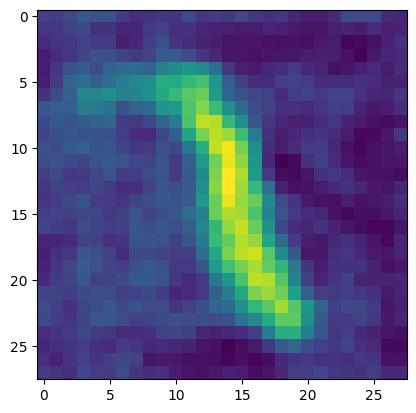

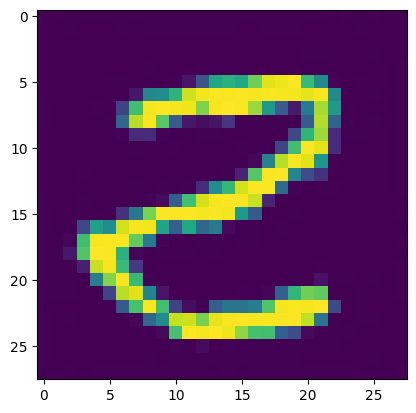

Regularization Term    tensor(-0.2550, device='cuda:0', grad_fn=<NegBackward0>)
2.0173827172553973e+118
Epoch: 0   Loss: tensor(0.6594, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4128, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


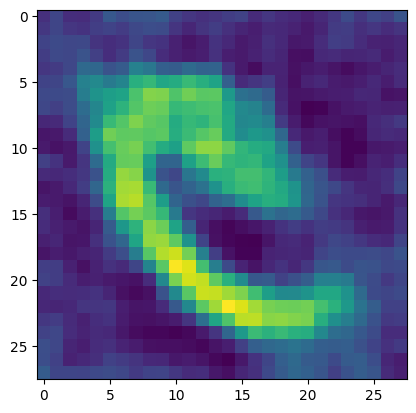

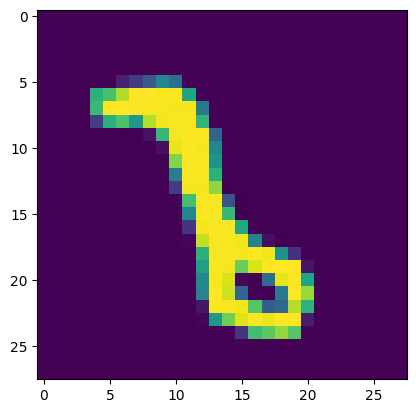

Regularization Term    tensor(-0.2550, device='cuda:0', grad_fn=<NegBackward0>)
6.698341053387061e+116
Epoch: 0   Loss: tensor(0.5692, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3775, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1354, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


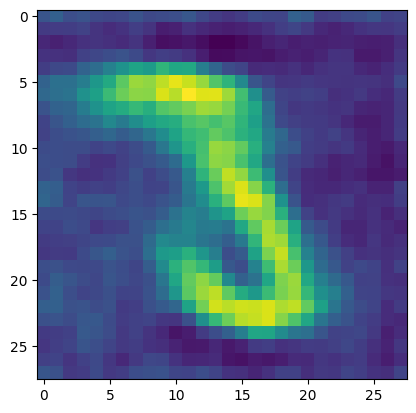

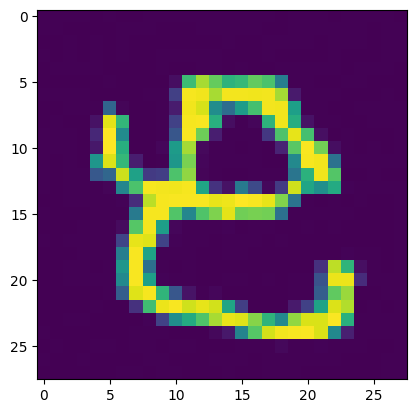

Regularization Term    tensor(-0.2313, device='cuda:0', grad_fn=<NegBackward0>)
5.686851884435831e+100
Epoch: 0   Loss: tensor(0.6839, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4065, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1303, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


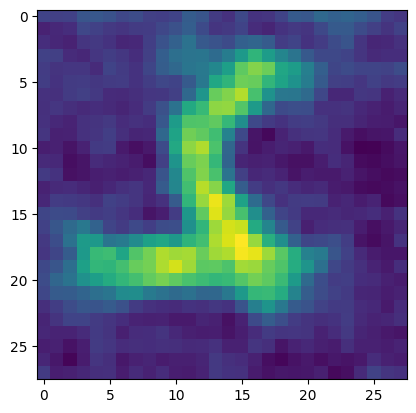

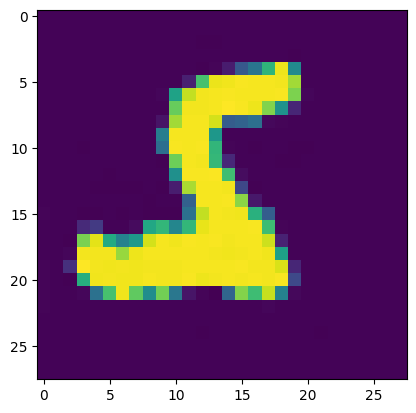

Regularization Term    tensor(-0.2582, device='cuda:0', grad_fn=<NegBackward0>)
1.3531641834341422e+107
Epoch: 0   Loss: tensor(0.5355, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3677, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1325, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


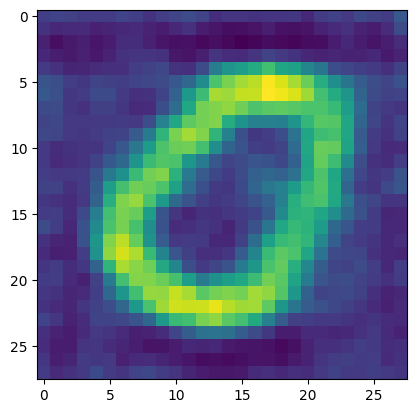

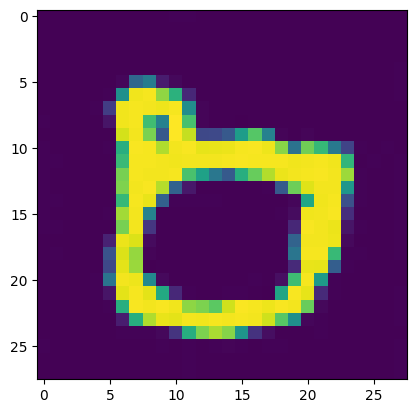

Regularization Term    tensor(-0.2603, device='cuda:0', grad_fn=<NegBackward0>)
-4.3342206816033927e+117
Epoch: 0   Loss: tensor(0.5699, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3840, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1304, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


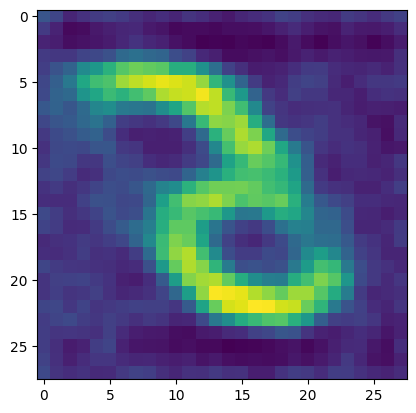

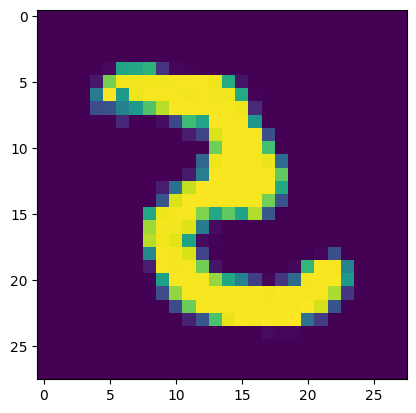

Regularization Term    tensor(-0.2614, device='cuda:0', grad_fn=<NegBackward0>)
1.371843654583905e+103
Epoch: 0   Loss: tensor(0.5628, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3828, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1287, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


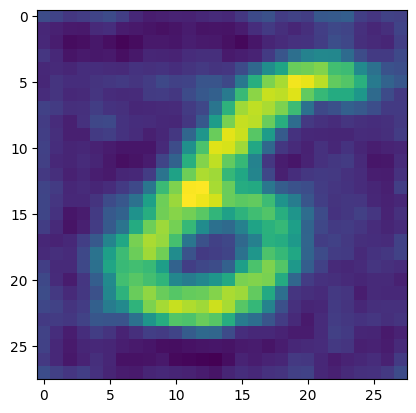

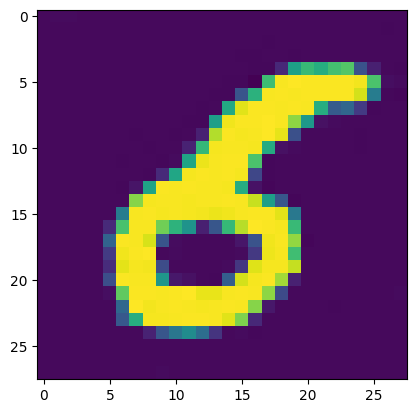

Regularization Term    tensor(-0.2571, device='cuda:0', grad_fn=<NegBackward0>)
-1.155923302458996e+108
Epoch: 0   Loss: tensor(0.6200, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4015, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1303, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


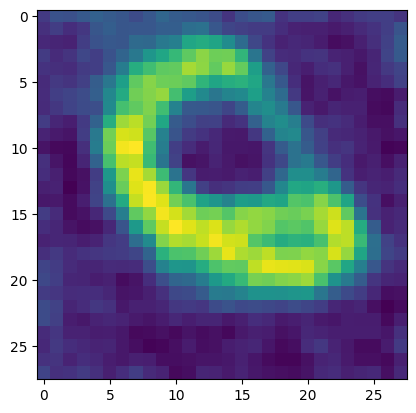

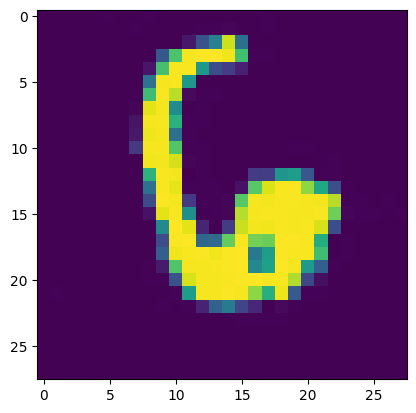

Regularization Term    tensor(-0.2624, device='cuda:0', grad_fn=<NegBackward0>)
-2.4208592607064768e+119
Epoch: 0   Loss: tensor(0.5697, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3845, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1332, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


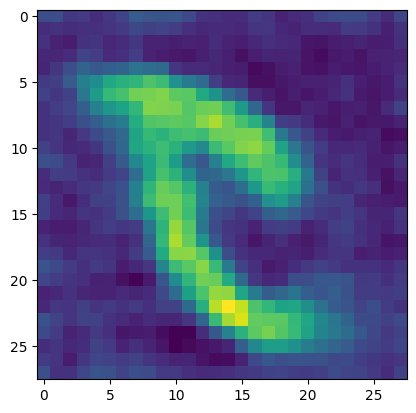

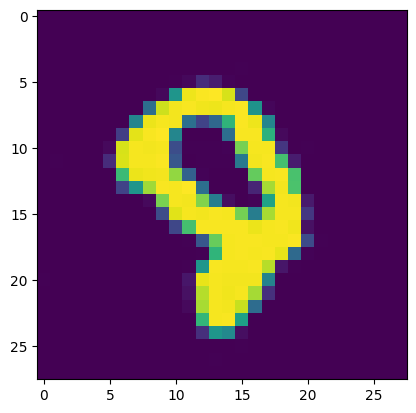

Regularization Term    tensor(-0.2567, device='cuda:0', grad_fn=<NegBackward0>)
-1.2318596081977923e+103
Epoch: 0   Loss: tensor(0.5671, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3810, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1281, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


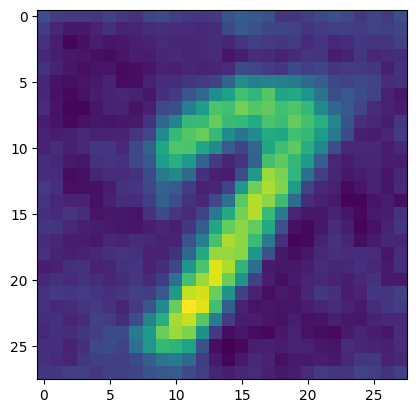

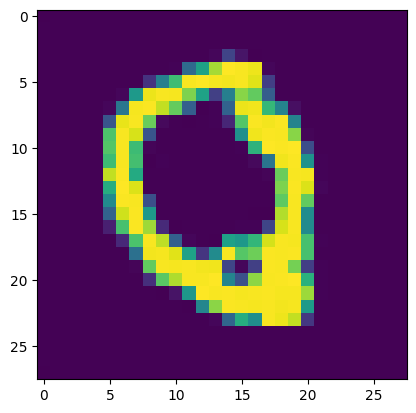

Regularization Term    tensor(-0.2616, device='cuda:0', grad_fn=<NegBackward0>)
-4.586997231980143e+105
Epoch: 0   Loss: tensor(0.6078, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4013, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


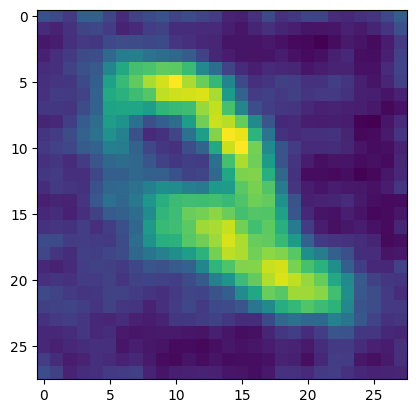

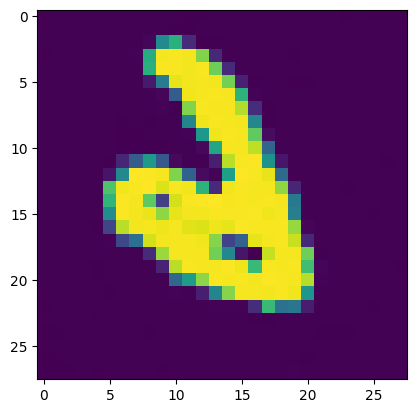

Regularization Term    tensor(-0.2705, device='cuda:0', grad_fn=<NegBackward0>)


KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()
epochs = 5

student_optimizer = Adam(student_model.parameters(), lr=1e-5)
scheduler_student = torch.optim.lr_scheduler.ReduceLROnPlateau(student_optimizer, 'min', patience=1, factor=0.05)

losses=[]
fid = []


for epoch in range(epochs):

    for step, batch in enumerate(dataloader):
      if step == 100:
        break

      student_optimizer.zero_grad()

      batch_size = batch[0].shape[0]
      batch = batch[0].to(device)

      t_teacher = torch.randint(0, teacher_timesteps*2, (batch_size,), device=device).long()

      noise = torch.randn_like(batch)

      input= torch.rand([64,1,28,28]).to(device)

      student_data = sample( student_model,  input , image_size, timestep=student_timesteps,  batch_size=batch_size, channels=channels)

      real_labels = torch.ones(batch_size, 1).to(device)

      output_fake = discriminator_model(student_data[-1])
      loss_fake = disc_loss(output_fake, real_labels)

      x_noisy_teacher = q_sample(x_start = student_data[-1], t=t_teacher, noise = noise)

      with torch.no_grad():

        teacher_data = sample( teacher_model, x_noisy_teacher[0] , image_size, timestep=teacher_timesteps,  batch_size=batch_size, channels=channels)

      #show the results
      random_index = random.randint(0, 63)
      image_data1 = student_data[-1][random_index].cpu().detach().numpy().reshape(image_size, image_size, channels)
      image_data3 = teacher_data[-1][random_index].cpu().numpy().reshape(image_size, image_size, channels)
      plt.imshow(image_data1)
      plt.show()
      plt.imshow(image_data3)
      plt.show()

      distill_loss = dis_loss(teacher_data[-1] , student_data[-1])

      #regularization term useful to avoid mode collapse
      diversity_loss = -torch.mean(torch.abs(student_data[-1]  - student_data[-1].mean(dim=0)))
      print("Regularization Term    " + str(diversity_loss))

      loss = l*distill_loss + loss_fake +  regularization_term  * diversity_loss
      losses.append(loss)

      batch_resized = resize_images(batch)
      student_data_resized = resize_images(student_data[-1])

      batch_expanded = batch_resized.repeat(1, 3, 1, 1)
      student_data_expanded = student_data_resized.repeat(1, 3, 1, 1)

      #LA FID è IL METRO DI VALUTAZIONE DELL'EFFICENZA DELLE RETI AVVERSARIE E VA  CALCOLATA BASANDOSI
      #SULLA MEDIA E SULLA VARIANZA DELLE DISTRIBUZIONI DEI DATI REALI E GENERATI
      #IN QUESTO CASO MI DA VALORI TROPPO ALTI E DEVI CAPIRE PERCHè

      fid_loss = calculate_fid(batch_expanded, student_data_expanded)
      fid.append(fid_loss)
      print(fid_loss)

      print("Epoch: " + str(epoch) + "   Loss:", str(loss), "  Distillation Loss:" + str(distill_loss), " Adversarial Loss:" + str(loss_fake) )

      loss.backward()
      student_optimizer.step()

    scheduler_student.step(loss)

In [ ]:
#discriminator_path = '/content/drive/MyDrive/discriminator_model_last_version.pth'
#student_path = '/content/drive/MyDrive/student_model_last_version.pth'

# Salva il modello
#torch.save(discriminator_model.state_dict(), discriminator_path)
#torch.save(student_model.state_dict(), student_path)

In [ ]:
#path = '/content/drive/MyDrive/diffusion_model_last_version.pth'

# Salva il modello
#torch.save(teacher_model.state_dict(), path)

#Show results

In [20]:
image_size = 28
channels = 1
batch_size = 64
student_timesteps = 6
teacher_timesteps= 400

# path to load the pretrained models
diffusion_path = '../Neural_Network/models/models/diffusion_model_last_version.pth'
discriminator_path = '../Neural_Network/models/models/discriminator_model_last_version.pth'
student_path = '../Neural_Network/models/models/student_model_last_version.pth'


# Load the teacher_model
teacher_model = Unet(  dim=image_size,  channels=channels,  dim_mults=(1, 2, 4,))
teacher_model.load_state_dict(torch.load(diffusion_path))
teacher_model.eval()
teacher_model.to(device)

# Load the discriminator_model
discriminator_model = ViT(64, 512, 1, 1)
discriminator_model.load_state_dict(torch.load(discriminator_path))
discriminator_model.train()
discriminator_model.to(device)

# Load the student_model
student_model = Unet( dim=image_size, channels=channels, dim_mults=(1, 2, 4,))
student_model.load_state_dict(torch.load(student_path))
student_model.train()
student_model.to(device)

Unet(
  (init_conv): Conv2d(1, 18, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=28, out_features=112, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=112, out_features=112, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): UNet_ResNet(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=112, out_features=28, bias=True)
        )
        (block1): UNet_Block(
          (proj): Conv2d(18, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(4, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): UNet_Block(
          (proj): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(4, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Conv2d(18, 28, kernel_size=(1, 1), stride

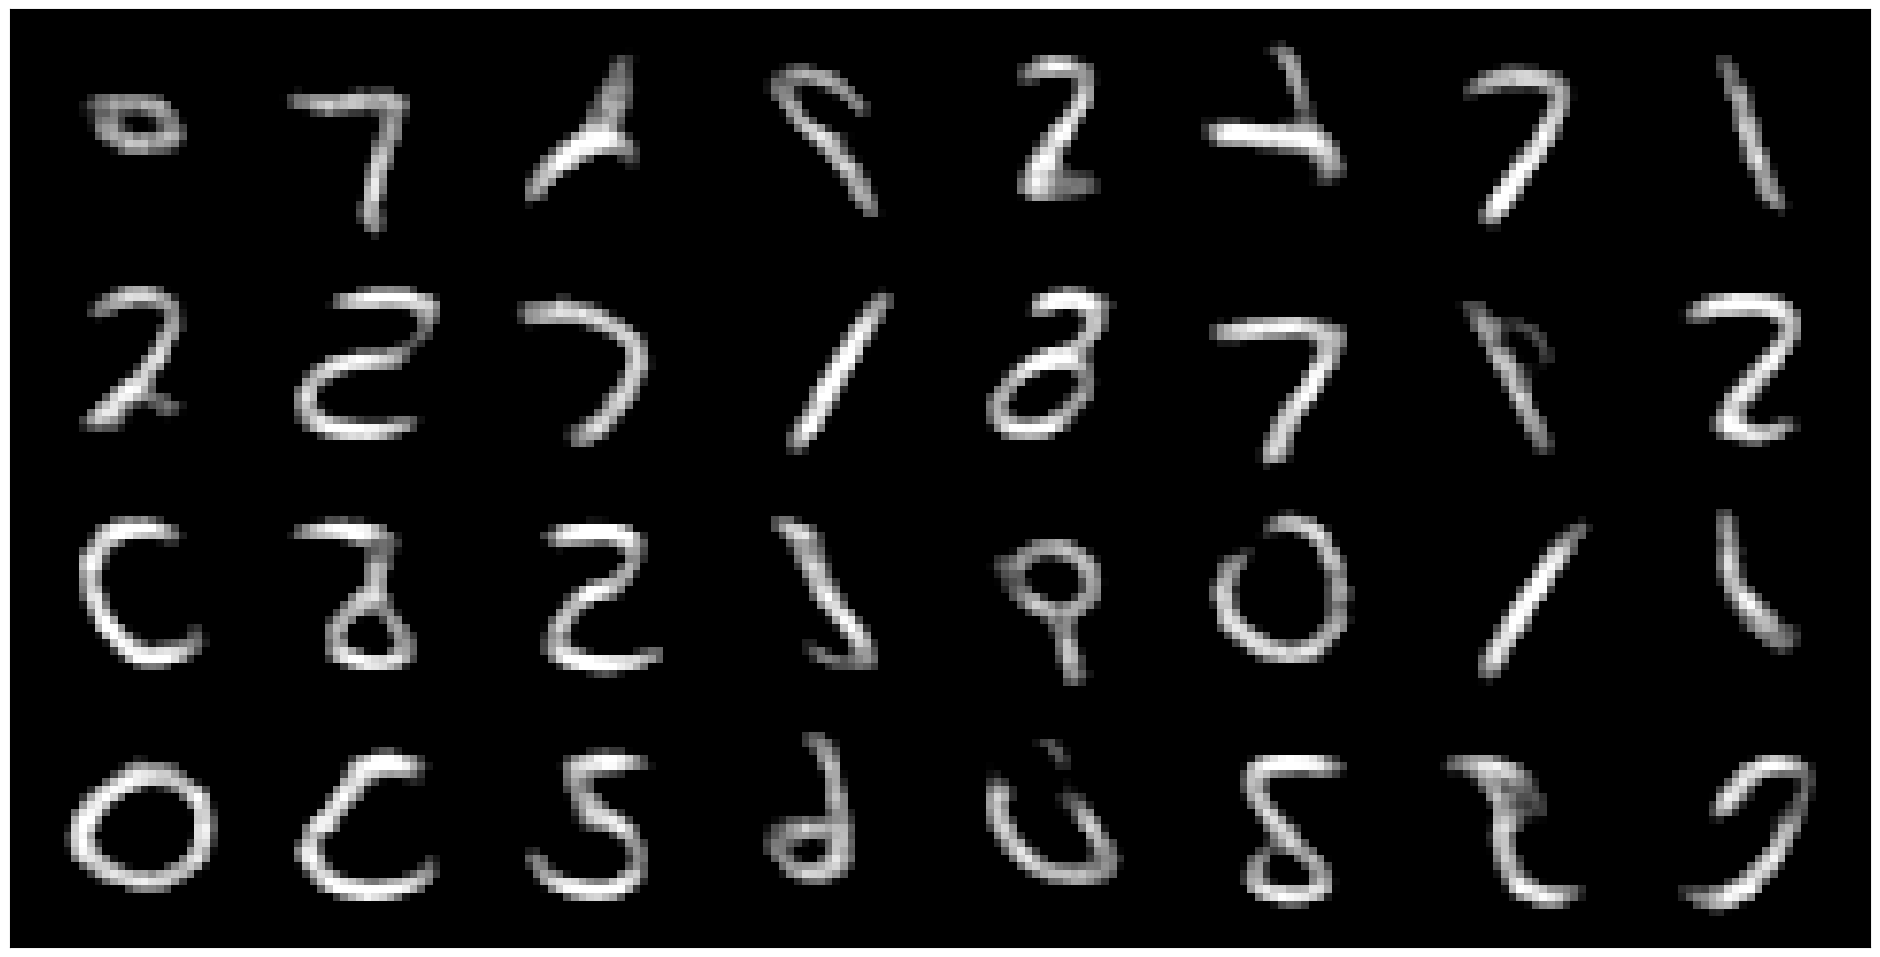

In [21]:
with torch.no_grad():
  pure_noise = torch.rand([64,1,28,28]).to(device)
  student_data = sample(student_model, pure_noise, image_size=image_size, timestep=8,  batch_size=BATCH_SIZE, channels=channels)
  show_batch(student_data[-1].cpu().detach())

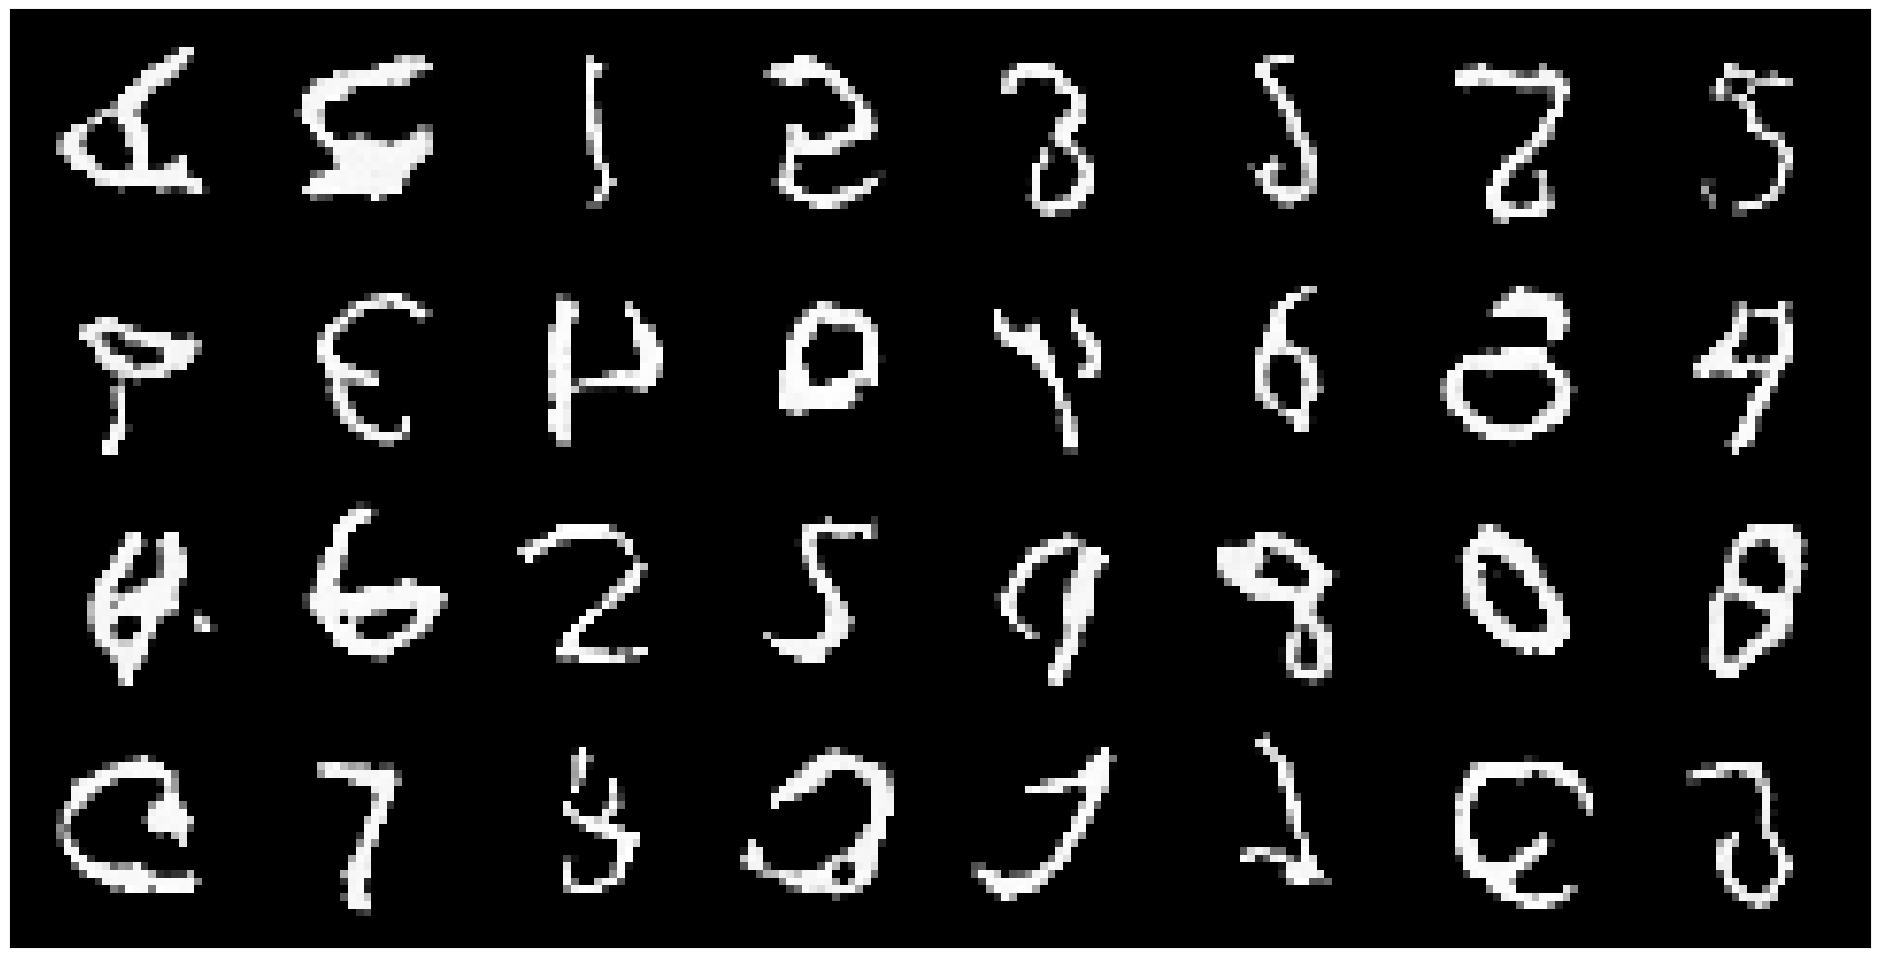

In [22]:
with torch.no_grad():
  #pure_noise = torch.rand([64,1,28,28]).to(device)
  teacher_data = sample(teacher_model, pure_noise, image_size=image_size, timestep=800,  batch_size=BATCH_SIZE, channels=channels)
  show_batch(teacher_data[-1].cpu().detach())

#Evaluate

In [23]:
torch.cuda.empty_cache()

In [57]:
from scipy.linalg import sqrtm
from torchvision.transforms import ToPILImage
from torchvision import models, transforms

# Carica il modello Inception v3 pre-addestrato
wrapper_model = models.inception_v3(pretrained=True)
wrapper_model.fc = torch.nn.Identity()
wrapper_model.eval()
wrapper_model.to(device)

transform = tt.Compose([
        tt.Grayscale(num_output_channels=3),  # Converti in scala di grigi a 3 canali
        tt.Resize((299, 299)),  # Inception v3 richiede immagini di dimensione 299x299
        tt.ToTensor(),
        tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# Funzione per ridimensionare un batch di immagini
def transform_images(images):
    to_pil_image = ToPILImage()
    resized_images = []
    for image in images:
        # Converti il tensore in un'immagine PIL, ridimensiona, e poi ritorna a un tensore
        pil_image = to_pil_image(image)
        #resized_pil_image = transform(pil_image)
        #resized_image = to_tensor(resized_pil_image)
        resized_image = transform(pil_image)
        resized_images.append(resized_image.unsqueeze(0))
    return torch.cat(resized_images, dim=0).to(device)


def calculate_fid(real_embeddings, generated_embeddings):
      # calculate mean and covariance statistics
      real = wrapper_model(real_embeddings.to(device))
      generated = wrapper_model(generated_embeddings.to(device))
      print(real)
      mu1, sigma1 = real.cpu().detach().numpy().mean(axis=0), np.cov(real.cpu().detach().numpy(), rowvar=False)
      mu2, sigma2 = generated.cpu().detach().numpy().mean(axis=0), np.cov(generated.cpu().detach().numpy(),  rowvar=False)
      # calculate sum squared difference between means
      ssdiff = np.sum((np.array(mu1) - np.array(mu2))**2.0)
      # calculate sqrt of product between cov
      covmean = sqrtm(sigma1.dot(sigma2))
      # check and correct imaginary numbers from sqrt
      if np.iscomplexobj(covmean):
        covmean = covmean.real
      # calculate score
      fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
      return fid

transformed_teacher = transform_images(teacher_data[-1])
transformed_student =  transform_images(student_data[-1])
print(calculate_fid(transformed_teacher, transformed_student))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor([[9.1831e-01, 1.4035e-01, 3.3905e-02,  ..., 7.6199e-01, 3.1007e-02,
         7.7192e-01],
        [6.3229e-01, 0.0000e+00, 1.3635e-02,  ..., 8.1355e-01, 1.9405e-01,
         9.5643e-01],
        [4.1889e-01, 1.2768e-04, 2.1804e-01,  ..., 1.1479e+00, 2.0301e-01,
         2.6018e-01],
        ...,
        [4.8388e-01, 8.0416e-03, 5.9965e-02,  ..., 6.9454e-01, 1.5504e-01,
         6.2405e-01],
        [3.9315e-01, 0.0000e+00, 3.8579e-02,  ..., 8.7588e-01, 0.0000e+00,
         9.9914e-03],
        [8.5382e-01, 9.0400e-04, 7.8223e-02,  ..., 1.1799e-01, 2.2061e-01,
         4.3843e-01]], device='cuda:0', grad_fn=<ViewBackward0>)
1.9555545372811066e+92


In [29]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.7 MB/s eta 0:00:00


In [60]:
from torcheval import metrics
def calculate_fid(real_embeddings, generated_embeddings):
      # calculate mean and covariance statistics
      real = wrapper_model(real_embeddings.to(device))
      generated = wrapper_model(generated_embeddings.to(device))
      print(real.shape)
      print(generated.shape)
      mu1, sigma1 = real.cpu().detach().numpy().mean(axis=1), np.cov(real.cpu().detach().numpy(), rowvar=False)
      mu2, sigma2 = generated.cpu().detach().numpy().mean(axis=1), np.cov(generated.cpu().detach().numpy(),  rowvar=False)
      print(real.cpu().detach().numpy().mean(axis=1).mean(axis=0))
      print(generated.cpu().detach().numpy().mean(axis=1).mean(axis=0))
      print(np.cov(real.cpu().detach().numpy(), rowvar=False))
      # calculate sum squared difference between means
      ssdiff = np.sum((np.array(mu1) - np.array(mu2))**2.0)
      print(ssdiff)
      # calculate sqrt of product between cov
      covmean = sqrtm(sigma1.dot(sigma2))
      # check and correct imaginary numbers from sqrt
      if np.iscomplexobj(covmean):
        covmean = covmean.real
      # calculate score
      fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
      return fid

fid_metrics = metrics.FrechetInceptionDistance(wrapper_model, 2048).to(device)
#fid_metrics.update(torch.cat([transform_images(teacher_data[-1]),transform_images(student_data[-1])]), is_real_tensor)
fid_metrics.update(transform_images(teacher_data[-1]).to(device), is_real=True)
fid_metrics.update(transform_images(student_data[-1]).to(device), is_real=False)
fid_metrics.compute()


torch.Size([128, 3, 299, 299])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])


tensor(233.3238, device='cuda:0')

In [ ]:
import torch
from torchvision import models, transforms
from scipy.linalg import sqrtm
import numpy as np

def calculate_fid(act1, act2):
    # Calcola media e covarianza delle caratteristiche
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # Calcola la differenza delle medie al quadrato
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # Calcola la radice quadrata del prodotto delle matrici di covarianza
    covmean = sqrtm(sigma1.dot(sigma2))

    # Verifica se è una matrice complessa a causa di errori numerici e prendi il reale
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calcola la FID
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def get_activations(images, model, batch_size=64, dims=2048, device='cpu'):
    model.eval()
    model.to(device)
    # Preparazione del DataLoader
    dataloader = torch.utils.data.DataLoader(images, batch_size=batch_size )

    # Estrazione delle caratteristiche
    pred_arr = np.empty((len(images), dims))
    for i, batch in enumerate(dataloader):
        batch = batch[0].to(device)
        with torch.no_grad():
            pred = model(batch)
        pred_arr[i * batch_size:i * batch_size + batch.size(0)] = pred.cpu().numpy()

    return pred_arr

# Carica il modello Inception v3 pre-addestrato
model = models.inception_v3(pretrained=True)
model.fc = torch.nn.Identity() # Modifica l'ultimo layer per ottenere le caratteristiche

# Assumi che `real_images` e `generated_images` siano i tuoi PyTorch Datasets
# Devi applicare le trasformazioni necessarie per portarli nel formato richiesto da Inception v3
transform_to_rgb = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  # Converti in scala di grigi a 3 canali
        transforms.Resize((299, 299)),  # Inception v3 richiede immagini di dimensione 299x299
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Ridimensiona le immagini a 299x299
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Ripeti il canale per convertire in RGB
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalizza come per Inception v3
])

fake_images = torch.stack([transform(img) for img in student_data[-1]])
real_images = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_to_rgb)
# Calcola le attivazioni per entrambi i set di immagini
real_activations = get_activations(fake_images, model, device='cuda')
generated_activations = get_activations(real_images, model, device='cuda')


# Calcola la FID
fid_value = calculate_fid(real_activations, generated_activations)
print(f'FID score: {fid_value}')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (r

ValueError: expected 4D input (got 3D input)